In [ ]:
!nvidia-smi
!nvcc --version
import torch; print(torch.cuda.is_available(), torch.cuda.get_device_name(0))

Sun Oct 26 14:19:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import precision_score, recall_score
import numpy as np
from collections import defaultdict
from torchsummary import summary

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# =========================
# Colab: Mount, find, unzip, and set data_dir for LI-Small_Trans
# =========================

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os, zipfile, re
from pathlib import Path

TARGET_BASENAME = "HI-LI-Datasets"     # change only if your folder/zip is named differently
MYDRIVE = Path("/content/drive/MyDrive")
EXTRACT_PATH = Path(f"/content/{TARGET_BASENAME}")   # runtime path

def find_targets(root: Path, target: str):
    """
    Recursively search for:
      1) A folder named exactly `target` (case-insensitive)
      2) A zip with name that equals `target` or contains it (case-insensitive)
    Returns (folder_path or None, zip_path or None)
    """
    target_lower = target.lower()
    found_folder = None
    found_zip = None

    # Walk MyDrive (shallow to moderate depth to keep it fast)
    # If your Drive is huge, you can raise max_depth or skip depth checks.
    max_depth = 6
    def depth(p: Path):
        try:
            return len(p.relative_to(root).parts)
        except ValueError:
            return 0

    for dirpath, dirnames, filenames in os.walk(root):
        dirpath_p = Path(dirpath)

        # Depth guard
        if depth(dirpath_p) > max_depth:
            # prune deeper levels
            dirnames[:] = []
            continue

        # Check folders for exact match first (case-insensitive)
        for d in dirnames:
            if d.lower() == target_lower:
                found_folder = dirpath_p / d
                # We keep searching for a better zip match too, but you could break here.

        # Check zip candidates
        for f in filenames:
            if f.lower().endswith(".zip"):
                name_wo_ext = f[:-4].lower()
                # prefer exact name zip; else contains
                if name_wo_ext == target_lower or target_lower in f.lower():
                    candidate = dirpath_p / f
                    # prefer exact match over "contains"
                    if found_zip is None or name_wo_ext == target_lower:
                        found_zip = candidate

    return found_folder, found_zip

# --- Find the folder or zip ---
folder_path, zip_path = find_targets(MYDRIVE, TARGET_BASENAME)

print("Search results under My Drive:")
print("  Folder found:", folder_path if folder_path else "None")
print("  ZIP found   :", zip_path if zip_path else "None")

# --- Decide how to proceed ---
if folder_path is None and zip_path is None:
    # Give helpful context to debug path issues
    print("\nCould not find a folder or zip matching:", TARGET_BASENAME)
    print("Here are some items in your My Drive to double-check names:")
    try:
        for entry in sorted(MYDRIVE.iterdir()):
            print(" -", entry.name)
    except Exception as e:
        print("Error listing My Drive:", e)
    raise FileNotFoundError(
        f"Neither a folder nor a zip named like '{TARGET_BASENAME}' was found in My Drive.\n"
        "Tip: Ensure it's in 'My Drive' (not Shared drives) and the spelling matches."
    )

# If we found a folder named LI-Small_Trans, check if there is a zip inside it.
if folder_path:
    inner_zips = [p for p in folder_path.rglob("*.zip")]
    if inner_zips:
        # Prefer a zip whose basename matches the target
        preferred = [p for p in inner_zips if p.stem.lower() == TARGET_BASENAME.lower()]
        zip_in_folder = preferred[0] if preferred else inner_zips[0]
    else:
        zip_in_folder = None
else:
    zip_in_folder = None

# Priority for extraction:
# 1) zip found inside the LI-Small_Trans folder
# 2) zip found anywhere in MyDrive that matches the name
zip_to_use = zip_in_folder or zip_path

# Extract if needed
if zip_to_use:
    if not EXTRACT_PATH.exists():
        EXTRACT_PATH.mkdir(parents=True, exist_ok=True)
        print(f"\nExtracting ZIP:\n  {zip_to_use}\n  -> {EXTRACT_PATH}")
        with zipfile.ZipFile(str(zip_to_use), 'r') as zf:
            zf.extractall(str(EXTRACT_PATH))
        print("Dataset unzipped!")
    else:
        print(f"\nDataset already extracted at: {EXTRACT_PATH}")
else:
    # No zip to extract; assume the folder itself is the dataset
    if not EXTRACT_PATH.exists():
        # Optionally mirror the folder into /content for faster access (skipped by default)
        # For simplicity, just point data_dir to the folder in Drive.
        pass

# --- Decide data_dir ---
# If we extracted, use EXTRACT_PATH; else use folder_path directly.
base_dir = EXTRACT_PATH if EXTRACT_PATH.exists() else folder_path

# Heuristic: if there's a subfolder named 'dataset', prefer that
candidates = [p for p in base_dir.iterdir() if p.is_dir()]
dataset_sub = None
for c in candidates:
    if c.name.lower() == "dataset":
        dataset_sub = c
        break

data_dir = dataset_sub if dataset_sub else base_dir
print("\nData directory set to:\n ", data_dir)

# --- Preview: list a few files/folders ---
def preview_tree(root: Path, max_files=25):
    print("\nSample of extracted contents:")
    shown = 0
    for dirpath, dirnames, filenames in os.walk(root):
        # Print folder
        rel_dir = os.path.relpath(dirpath, root)
        print(f"[{rel_dir}]")
        for d in sorted(dirnames):
            print("  <DIR> ", d)
        for f in sorted(filenames):
            print("        ", f)
            shown += 1
            if shown >= max_files:
                print("... (more files omitted)")
                return
        if shown >= max_files:
            return

preview_tree(data_dir)

# --- Optional: Preview the first CSV found ---
# Uncomment to auto-preview a CSV head.
# import pandas as pd
# first_csv = None
# for p in data_dir.rglob("*.csv"):
#     first_csv = p
#     break
# if first_csv:
#     print("\nPreview of:", first_csv)
#     try:
#         display(pd.read_csv(first_csv).head())
#     except Exception as e:
#         print("Couldn't read CSV due to:", e)
# else:
#     print("\nNo CSV files found under:", data_dir)


Mounted at /content/drive
Search results under My Drive:
  Folder found: None
  ZIP found   : /content/drive/MyDrive/HI-LI-Datasets.zip

Extracting ZIP:
  /content/drive/MyDrive/HI-LI-Datasets.zip
  -> /content/HI-LI-Datasets
Dataset unzipped!

Data directory set to:
  /content/HI-LI-Datasets

Sample of extracted contents:
[.]
  <DIR>  __MACOSX
         HI-Small_Trans.csv
         HI-Small_patterns.txt
         LI-Small_Trans.csv
         LI-Small_patterns.txt
[__MACOSX]
         ._HI-Small_Trans.csv
         ._HI-Small_patterns.txt
         ._LI-Small_Trans.csv
         ._LI-Small_patterns.txt


In [ ]:
# Read all the 4 files, split the files with patterns to meaningful columns and load all the 4 files to data frames

import pandas as pd
import os

# Define your data directory
#data_dir = "your/data/directory/path"

# Dictionary to hold DataFrames keyed by filename
dataframes = {}

# Define column names for laundering patterns
pattern_columns = [
    "Timestamp", "TransactionID", "SenderAccount", "SenderBankCode", "ReceiverAccount",
    "AmountSent", "CurrencySent", "AmountReceived", "CurrencyReceived", "Method", "Flag", "PatternID"
]

# Walk through all files in the directory tree
for root, _, files in os.walk(data_dir):
    for f in files:
        # Skip Mac system files and hidden metadata
        if "__MACOSX" in root or f.startswith("._"):
            continue
        if f.lower().endswith((".csv", ".txt")):
            file_path = os.path.join(root, f)
            file_key = os.path.splitext(f)[0]  # Strip extension

            print(f"\n📄 Reading: {file_path}")
            if f.lower().endswith(".csv"):
                try:
                    df = pd.read_csv(file_path)
                    dataframes[file_key] = df
                    print(df.head(5))
                except Exception as e:
                    print(f"⚠️ pandas failed to read {file_path}: {e}")
            else:  # TXT file
                try:
                    with open(file_path, "r", encoding="utf-8") as file:
                        lines = [line.strip() for line in file if line.strip()]

                    records = []
                    pattern_id = 0
                    inside_block = False

                    for line in lines:
                        if line.startswith("BEGIN LAUNDERING ATTEMPT"):
                            inside_block = True
                            pattern_id += 1
                            current_pattern = f"Pattern_{pattern_id:03d}"
                        elif line.startswith("END LAUNDERING ATTEMPT"):
                            inside_block = False
                        elif inside_block:
                            fields = line.split(",")
                            if len(fields) == len(pattern_columns) - 1:
                                fields.append(current_pattern)
                                records.append(fields)

                    if records:
                        df = pd.DataFrame(records, columns=pattern_columns)
                        df["AmountSent"] = pd.to_numeric(df["AmountSent"], errors="coerce")
                        df["AmountReceived"] = pd.to_numeric(df["AmountReceived"], errors="coerce")
                        df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
                        dataframes[file_key] = df
                        print(df.head(5))
                    else:
                        print(f"⚠️ No valid laundering blocks found in {file_path}")
                except Exception as e:
                    print(f"❌ Failed to parse {file_path} as laundering pattern: {e}")

# Summary
if not dataframes:
    print("⚠️ No usable CSV or TXT files found inside:", data_dir)
else:
    print(f"\n✅ Loaded {len(dataframes)} files into structured DataFrames.")


📄 Reading: /content/HI-LI-Datasets/LI-Small_Trans.csv
          Timestamp  From Bank    Account  To Bank  Account.1  \
0  2022/09/01 00:08         11  8000ECA90       11  8000ECA90   
1  2022/09/01 00:21       3402  80021DAD0     3402  80021DAD0   
2  2022/09/01 00:00         11  8000ECA90     1120  8006AA910   
3  2022/09/01 00:16       3814  8006AD080     3814  8006AD080   
4  2022/09/01 00:00         20  8006AD530       20  8006AD530   

   Amount Received Receiving Currency  Amount Paid Payment Currency  \
0       3195403.00          US Dollar   3195403.00        US Dollar   
1          1858.96          US Dollar      1858.96        US Dollar   
2        592571.00          US Dollar    592571.00        US Dollar   
3            12.32          US Dollar        12.32        US Dollar   
4          2941.56          US Dollar      2941.56        US Dollar   

  Payment Format  Is Laundering  
0   Reinvestment              0  
1   Reinvestment              0  
2         Cheque         

In [ ]:
# List all loaded DataFrame names and preview their contents
print("\n📂 Loaded DataFrames:")
for name, df in dataframes.items():
    print(f"\n🔹 DataFrame name: '{name}'")
    print(df.head(5))  # You can change 5 to any number of rows you'd like to preview


📂 Loaded DataFrames:

🔹 DataFrame name: 'LI-Small_Trans'
          Timestamp  From Bank    Account  To Bank  Account.1  \
0  2022/09/01 00:08         11  8000ECA90       11  8000ECA90   
1  2022/09/01 00:21       3402  80021DAD0     3402  80021DAD0   
2  2022/09/01 00:00         11  8000ECA90     1120  8006AA910   
3  2022/09/01 00:16       3814  8006AD080     3814  8006AD080   
4  2022/09/01 00:00         20  8006AD530       20  8006AD530   

   Amount Received Receiving Currency  Amount Paid Payment Currency  \
0       3195403.00          US Dollar   3195403.00        US Dollar   
1          1858.96          US Dollar      1858.96        US Dollar   
2        592571.00          US Dollar    592571.00        US Dollar   
3            12.32          US Dollar        12.32        US Dollar   
4          2941.56          US Dollar      2941.56        US Dollar   

  Payment Format  Is Laundering  
0   Reinvestment              0  
1   Reinvestment              0  
2         Cheque      

In [ ]:
# Starting off with EDA

for name, df in dataframes.items():
    print(f"\n📄 DataFrame: {name}")
    print(df.info())
    print(df.head())


📄 DataFrame: LI-Small_patterns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Timestamp         1023 non-null   datetime64[ns]
 1   TransactionID     1023 non-null   object        
 2   SenderAccount     1023 non-null   object        
 3   SenderBankCode    1023 non-null   object        
 4   ReceiverAccount   1023 non-null   object        
 5   AmountSent        1023 non-null   float64       
 6   CurrencySent      1023 non-null   object        
 7   AmountReceived    1023 non-null   float64       
 8   CurrencyReceived  1023 non-null   object        
 9   Method            1023 non-null   object        
 10  Flag              1023 non-null   object        
 11  PatternID         1023 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 96.0+ KB
None
            Timestamp Transa

In [ ]:
# Checking for missing values and duplicates
for name, df in dataframes.items():
    print(f"\n🔍 Missing values in {name}:")
    print(df.isnull().sum())
    print(f"🧹 Duplicates in {name}: {df.duplicated().sum()}")



🔍 Missing values in LI-Small_Trans:
Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64
🧹 Duplicates in LI-Small_Trans: 8

🔍 Missing values in LI-Small_patterns:
Timestamp           0
TransactionID       0
SenderAccount       0
SenderBankCode      0
ReceiverAccount     0
AmountSent          0
CurrencySent        0
AmountReceived      0
CurrencyReceived    0
Method              0
Flag                0
PatternID           0
dtype: int64
🧹 Duplicates in LI-Small_patterns: 0

🔍 Missing values in HI-Small_Trans:
Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering        

In [ ]:
for name, df in dataframes.items():
    print(f"\n🔍 Checking duplicates in: {name}")
    num_duplicates = df.duplicated().sum()
    print(f"🧭 Total duplicate rows: {num_duplicates}")

    if num_duplicates > 0:
        print(f"\n📋 Duplicate rows in {name}:")
        print(df[df.duplicated()])
    else:
        print("✅ No duplicate rows found.")



🔍 Checking duplicates in: LI-Small_Trans
🧭 Total duplicate rows: 8

📋 Duplicate rows in LI-Small_Trans:
                Timestamp  From Bank    Account  To Bank  Account.1  \
676696   2022/09/01 05:03      21260  8085A09D1    72146  81AB967E1   
790830   2022/09/01 07:44     231616  814E45511   171546  81B324AC1   
2027616  2022/09/02 11:09      28335  804B468F1   171669  81BBCDAB1   
3482553  2022/09/05 12:44      22661  80D016C81   269294  81A245E81   
4180131  2022/09/06 14:16      19970  804E44F11   169489  8197DC971   
4559112  2022/09/07 03:42     113016  80A4D8561   113016  80A4D8560   
4559113  2022/09/07 03:42     113016  80A4D8561   169261  81993FDE1   
6422482  2022/09/09 17:56      11701  8034B3501   273006  81B49ADC1   

         Amount Received Receiving Currency  Amount Paid Payment Currency  \
676696          0.000001            Bitcoin     0.000001          Bitcoin   
790830          0.000001            Bitcoin     0.000001          Bitcoin   
2027616         0.000007

In [ ]:
# Removing duplidates and checking the count after removing duplicates

for name, df in dataframes.items():
    original_count = len(df)
    deduped_df = df.drop_duplicates()
    deduped_count = len(deduped_df)

    print(f"\n📄 DataFrame: {name}")
    print(f"🔢 Original row count: {original_count}")
    print(f"🧹 After removing duplicates: {deduped_count}")
    print(f"🧭 Duplicates removed: {original_count - deduped_count}")

    # Update the dictionary with the cleaned DataFrame
    dataframes[name] = deduped_df



📄 DataFrame: LI-Small_Trans
🔢 Original row count: 6924049
🧹 After removing duplicates: 6924041
🧭 Duplicates removed: 8

📄 DataFrame: LI-Small_patterns
🔢 Original row count: 1023
🧹 After removing duplicates: 1023
🧭 Duplicates removed: 0

📄 DataFrame: HI-Small_Trans
🔢 Original row count: 5078345
🧹 After removing duplicates: 5078336
🧭 Duplicates removed: 9

📄 DataFrame: HI-Small_patterns
🔢 Original row count: 3209
🧹 After removing duplicates: 3209
🧭 Duplicates removed: 0



💸 Summary stats for LI-Small_Trans - Amount Received:
count    6.924041e+06
mean     6.324074e+06
std      2.105372e+09
min      1.000000e-06
25%      1.742100e+02
50%      1.397630e+03
75%      1.229653e+04
max      3.644854e+12
Name: Amount Received, dtype: float64


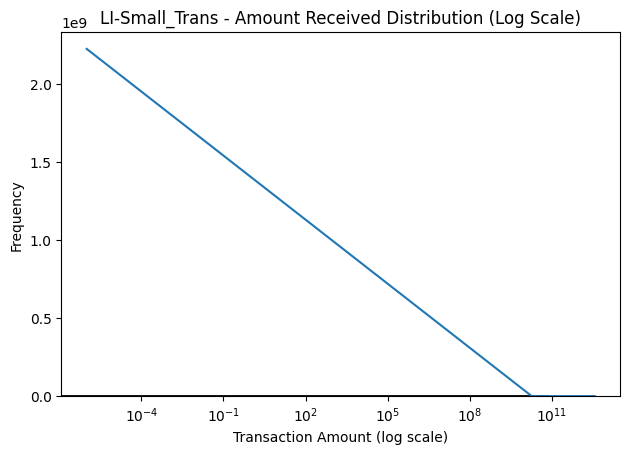

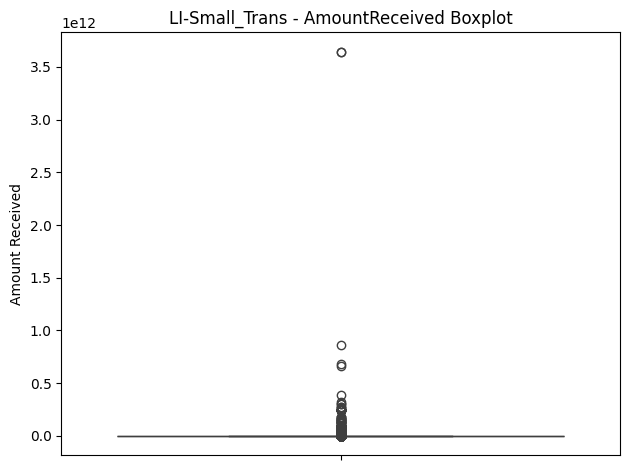


💸 Summary stats for HI-Small_Trans - Amount Received:
count    5.078336e+06
mean     5.988737e+06
std      1.037184e+09
min      1.000000e-06
25%      1.833700e+02
50%      1.411040e+03
75%      1.234630e+04
max      1.046302e+12
Name: Amount Received, dtype: float64


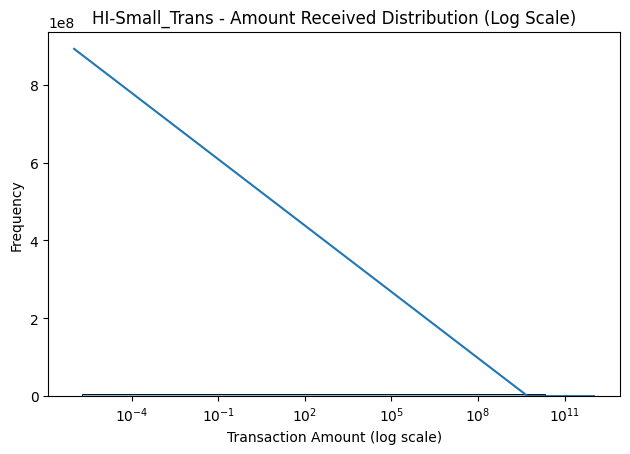

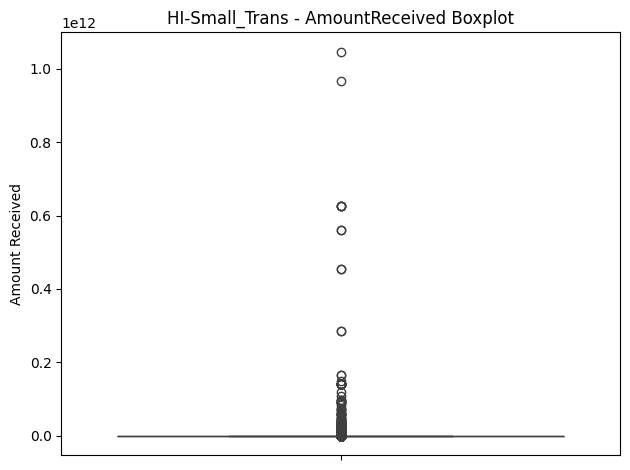

In [ ]:
# Transaction Amount Distribution

import seaborn as sns
import matplotlib.pyplot as plt

for name, df in dataframes.items():
    # Only process DataFrames whose name ends with 'Trans'
    if name.endswith("Trans"):
        for amount_col in ["Amount Sent", "Amount Received"]:
            if amount_col in df.columns:
                print(f"\n💸 Summary stats for {name} - {amount_col}:")
                print(df[amount_col].describe())

                # Filter out non-positive values to avoid log scale issues
                valid_amounts = df[df[amount_col] > 0][amount_col]

                if not valid_amounts.empty:
                    sns.histplot(valid_amounts, bins=50, kde=True)
                    plt.xscale("log")
                    plt.title(f"{name} - {amount_col} Distribution (Log Scale)")
                    plt.xlabel("Transaction Amount (log scale)")
                    plt.ylabel("Frequency")
                    plt.tight_layout()
                    plt.show()


                    sns.boxplot(valid_amounts)
                    plt.title(f"{name} - AmountReceived Boxplot")
                    plt.tight_layout()
                    plt.show()
                else:
                    print(f"⚠️ No positive values in {amount_col} for log scaling.")


In [ ]:
## Identify the top senders and receivers

for name, df in dataframes.items():
    # Only process DataFrames whose name ends with 'Trans'
    if name.endswith("Trans"):
        if "Account" in df.columns and "Account.1" in df.columns:
            print(f"\n📊 Top senders in {name}:")
            print(df["Account"].value_counts().head(10))

            print(f"\n📥 Top receivers in {name}:")
            print(df["Account.1"].value_counts().head(10))



📊 Top senders in LI-Small_Trans:
Account
10042B660    222037
10042B6A8    138777
10042B6F0     42385
10042B780     30802
10042BA51     28932
10042BA08     22417
10042B930     19445
10042B8A0     19254
10042B738     18213
10042B9C0     16266
Name: count, dtype: int64

📥 Top receivers in LI-Small_Trans:
Account.1
10042B660    1553
10042B6A8     951
10042B6F0     345
10042B780     223
10042BA08     170
10042B8A0     160
81632FCA0     140
10042B738     135
803878810     131
10042B930     131
Name: count, dtype: int64

📊 Top senders in HI-Small_Trans:
Account
100428660    168672
1004286A8    103018
100428978     20497
1004286F0     18663
100428780     17264
1004289C0     16794
100428810     16426
1004287C8     14174
100428738     13756
100428A51     13073
Name: count, dtype: int64

📥 Top receivers in HI-Small_Trans:
Account.1
100428660    1084
1004286A8     653
80F47A310     159
100428978     150
8018859B0     144
1004289C0     132
100428780     117
100428810     114
80F0EF460     109
1004

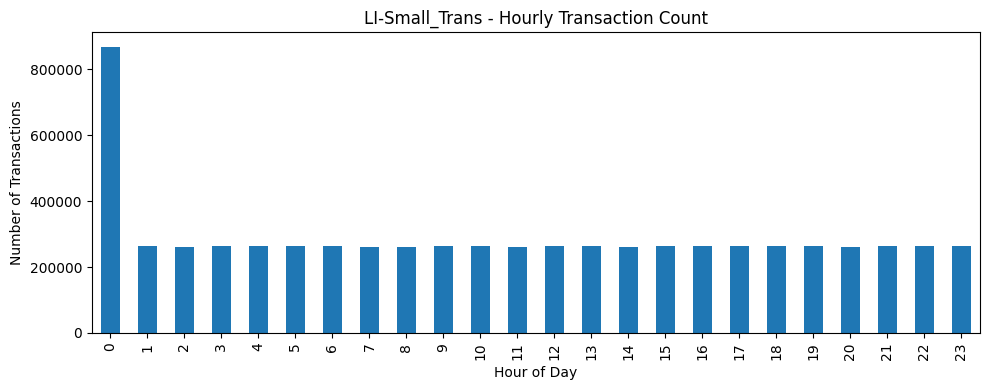

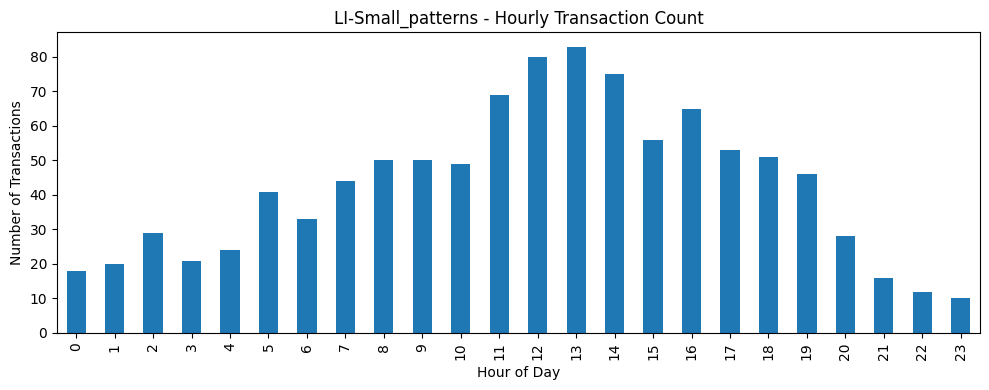

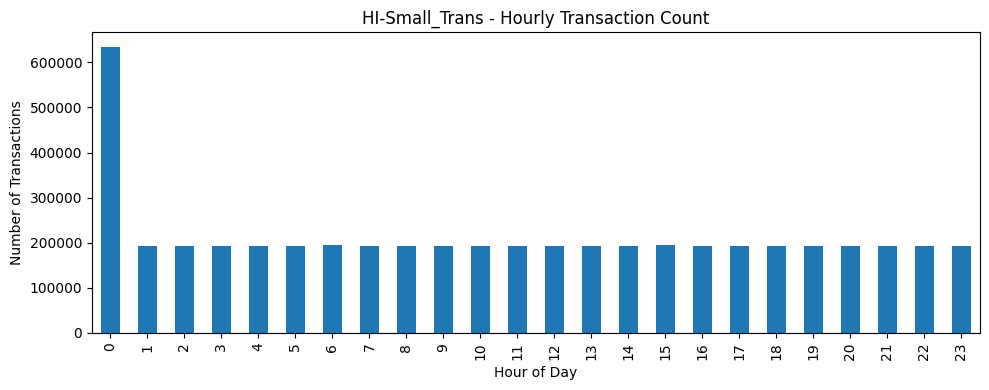

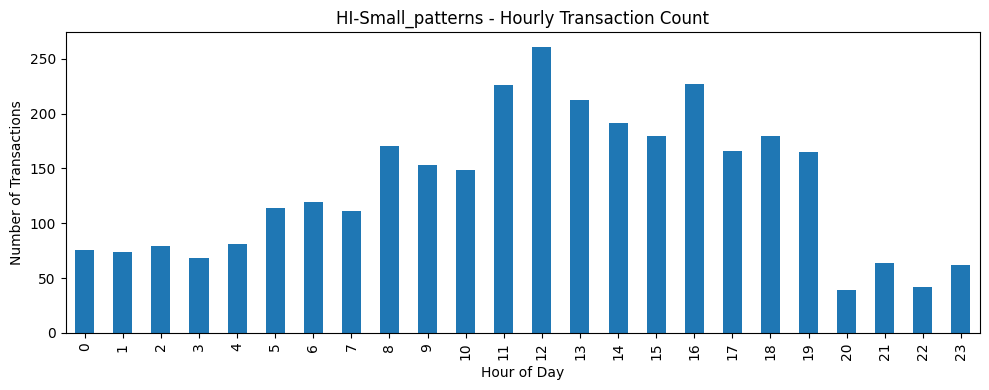

In [ ]:
# Checking the pattern of transactions and ML patterns at different hours of the day

import matplotlib.pyplot as plt
import pandas as pd  # Ensure pandas is imported

for name, df in dataframes.items():
    # Only process DataFrames whose name ends with 'Trans'
   # if name.endswith("Trans") and "Timestamp" in df.columns:
        # Convert Timestamp to datetime
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

        # Extract hour component
        df["Hour"] = df["Timestamp"].dt.hour

        # Group by hour and count transactions
        hourly_counts = df.groupby("Hour").size()

        # Plot hourly transaction volume
        hourly_counts.plot(kind="bar", title=f"{name} - Hourly Transaction Count", figsize=(10, 4))
        plt.xlabel("Hour of Day")
        plt.ylabel("Number of Transactions")
        plt.xticks(range(0, 24))  # Ensure all 24 hours are shown
        plt.tight_layout()
        plt.show()


In [ ]:
# To Detect structuring patterns in the ML patterns files

for name, df in dataframes.items():
    if name.endswith("patterns") and "SenderAccount" in df.columns:
        if "SenderAccount" in df.columns and "ReceiverAccount" in df.columns:
            fan_in = df.groupby("ReceiverAccount")["SenderAccount"].nunique()
            fan_out = df.groupby("SenderAccount")["ReceiverAccount"].nunique()
            print(f"\n🔗 Fan-In (unique senders per receiver) in {name}:")
            print(fan_in.sort_values(ascending=False).head(10))
            print(f"\n🔗 Fan-Out (unique receivers per sender) in {name}:")
            print(fan_out.sort_values(ascending=False).head(10))



🔗 Fan-In (unique senders per receiver) in LI-Small_patterns:
ReceiverAccount
80025E130    16
800A08E20    15
8012FC120    15
80021A8B0    14
800AF0650    13
80219F420    13
800299A70    12
800127B30    11
800130E70    10
801127C90    10
Name: SenderAccount, dtype: int64

🔗 Fan-Out (unique receivers per sender) in LI-Small_patterns:
SenderAccount
800077210    16
800603DB0    16
800701D70    15
80060B3A0    15
8004943A0    15
80BF623F0    14
800134F30    14
805756EB0    13
800774890    13
80016A780    12
Name: ReceiverAccount, dtype: int64

🔗 Fan-In (unique senders per receiver) in HI-Small_patterns:
ReceiverAccount
811ED7DF0    17
80AEBECB0    16
80465E020    16
809CC4600    16
8079DDC30    16
8028F2650    16
805D4C850    15
800924840    15
80098DC70    15
811D80C30    15
Name: SenderAccount, dtype: int64

🔗 Fan-Out (unique receivers per sender) in HI-Small_patterns:
SenderAccount
8040AE4F0    16
809BFD6B0    16
805DB7F20    16
80452D470    16
808338D40    16
800737690    16
8075AC7C0 

In [ ]:
# To Detect structuring patterns in the transactions file

for name, df in dataframes.items():
    if name.endswith("Trans") and "Account" in df.columns:
        if "Account" in df.columns and "Account.1" in df.columns:
            fan_in = df.groupby("Account.1")["Account"].nunique()
            fan_out = df.groupby("Account")["Account.1"].nunique()
            print(f"\n🔗 Fan-In (unique senders per receiver) in {name}:")
            print(fan_in.sort_values(ascending=False).head(10))
            print(f"\n🔗 Fan-Out (unique receivers per sender) in {name}:")
            print(fan_out.sort_values(ascending=False).head(10))



🔗 Fan-In (unique senders per receiver) in LI-Small_Trans:
Account.1
10042B660    785
10042B6A8    478
10042B6F0    176
10042B780    118
808283270     90
80AC3D4E0     90
818923590     89
80AEBC5F0     88
805ADEA90     87
8187275B0     87
Name: Account, dtype: int64

🔗 Fan-Out (unique receivers per sender) in LI-Small_Trans:
Account
10042B660    18942
10042B6A8    11877
10042B6F0     3611
10042B780     2620
10042BA51     2474
10042BA08     1928
10042B8A0     1637
10042B930     1594
10042B738     1560
10042B9C0     1370
Name: Account.1, dtype: int64

🔗 Fan-In (unique senders per receiver) in HI-Small_Trans:
Account.1
100428660    545
1004286A8    328
8051A3FA0     93
808FAF7C0     90
80B847A90     85
801AF5660     83
80F523260     83
80640FE10     83
80640B300     83
8146A9331     82
Name: Account, dtype: int64

🔗 Fan-Out (unique receivers per sender) in HI-Small_Trans:
Account
100428660    14230
1004286A8     8846
100428978     1776
1004286F0     1575
1004289C0     1432
100428780     1

In [ ]:
trans_master = pd.concat([dataframes[name] for name in dataframes if name.endswith("Trans")], ignore_index=True)
pattern_master = pd.concat([dataframes[name] for name in dataframes if name.endswith("patterns")], ignore_index=True)


In [ ]:
trans_master.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Hour
0,2022-09-01 00:08:00,11,8000ECA90,11,8000ECA90,3195403.00,US Dollar,3195403.00,US Dollar,Reinvestment,0,0
1,2022-09-01 00:21:00,3402,80021DAD0,3402,80021DAD0,1858.96,US Dollar,1858.96,US Dollar,Reinvestment,0,0
2,2022-09-01 00:00:00,11,8000ECA90,1120,8006AA910,592571.00,US Dollar,592571.00,US Dollar,Cheque,0,0
3,2022-09-01 00:16:00,3814,8006AD080,3814,8006AD080,12.32,US Dollar,12.32,US Dollar,Reinvestment,0,0
4,2022-09-01 00:00:00,20,8006AD530,20,8006AD530,2941.56,US Dollar,2941.56,US Dollar,Reinvestment,0,0


In [ ]:
# To analyse the transaction and the patterns - payment currency and payment method

for name, df in dataframes.items():
    if "CurrencySent" in df.columns or "Payment Currency" in df.columns:
        currency_col = "CurrencySent" if "CurrencySent" in df.columns else "Payment Currency"
        print(f"\n💱 Currency breakdown in {name}:")
        print(df[currency_col].value_counts())
    if "Method" in df.columns or "Payment Format" in df.columns:
        method_col = "Method" if "Method" in df.columns else "Payment Format"
        print(f"\n📬 Method breakdown in {name}:")
        print(df[method_col].value_counts())



💱 Currency breakdown in LI-Small_patterns:
CurrencySent
US Dollar            541
Euro                 414
Yuan                  19
Yen                   12
Australian Dollar     11
Canadian Dollar        7
Swiss Franc            4
Brazil Real            3
Rupee                  3
Saudi Riyal            2
Mexican Peso           2
Ruble                  2
UK Pound               1
Shekel                 1
Bitcoin                1
Name: count, dtype: int64

📬 Method breakdown in LI-Small_patterns:
Method
ACH        1022
Bitcoin       1
Name: count, dtype: int64

💱 Currency breakdown in LI-Small_Trans:
Payment Currency
US Dollar            2553886
Euro                 1595859
Yuan                  483603
Rupee                 340641
Bitcoin               309233
Saudi Riyal           257948
Australian Dollar     211155
Yen                   210125
Brazil Real           199840
Canadian Dollar       176069
Shekel                174530
Swiss Franc           138251
UK Pound               99668


In [ ]:
## Begin Feature Engineering

In [ ]:
## Merge the transaction files with the patterns files

import pandas as pd

# Extract relevant DataFrames
hi_patterns = dataframes["HI-Small_patterns"]
li_patterns = dataframes["LI-Small_patterns"]
hi_trans = dataframes["HI-Small_Trans"]
li_trans = dataframes["LI-Small_Trans"]

# Ensure Timestamp is datetime
for df in [hi_patterns, li_patterns, hi_trans, li_trans]:
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

# Merge HI and LI datasets separately
hi_merged = pd.merge(hi_trans, hi_patterns[["Timestamp", "PatternID"]], on="Timestamp", how="left")
li_merged = pd.merge(li_trans, li_patterns[["Timestamp", "PatternID"]], on="Timestamp", how="left")

# Combine merged datasets
merged_df = pd.concat([hi_merged, li_merged], ignore_index=True)


In [ ]:
merged_df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Hour,PatternID
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,0,NaN
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,0,NaN
2,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0,0,NaN
3,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0,0,NaN
4,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0,0,Pattern_001


In [ ]:
import numpy as np
import pandas as pd

# Step 1: Get unique PatternIDs
unique_patterns = merged_df["PatternID"].dropna().unique()
np.random.seed(42)
np.random.shuffle(unique_patterns)

# Step 2: Split PatternIDs into 70/15/15
n_total = len(unique_patterns)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

train_patterns = unique_patterns[:n_train]
val_patterns = unique_patterns[n_train:n_train + n_val]
test_patterns = unique_patterns[n_train + n_val:]

# Step 3: Filter merged_df based on PatternID
train_df = merged_df[merged_df["PatternID"].isin(train_patterns)]
val_df = merged_df[merged_df["PatternID"].isin(val_patterns)]
test_df = merged_df[merged_df["PatternID"].isin(test_patterns)]


NameError: name 'merged_df' is not defined

In [ ]:
import os

FEATURE_STORE_PATH = "feature_store"
os.makedirs(FEATURE_STORE_PATH, exist_ok=True)

def save_feature_table(df, feature_name):
    file_path = os.path.join(FEATURE_STORE_PATH, f"{feature_name}.parquet")
    df.to_parquet(file_path, index=False)
    print(f"✅ Saved: {feature_name}")

In [ ]:
train_df.to_parquet("feature_store/train_data.parquet", index=False)
val_df.to_parquet("feature_store/val_data.parquet", index=False)
test_df.to_parquet("feature_store/test_data.parquet", index=False)

In [ ]:
## First set of temporal features - Hour of the day mean and standard deviation

# Extract hour from Timestamp
train_df["Hour"] = train_df["Timestamp"].dt.hour

# Group by PatternID and compute mean and std
temporal_features = train_df.groupby("PatternID")["Hour"].agg(
    hour_of_day_mean="mean",
    hour_of_day_std="std"
).reset_index()

# Save temporal features
save_feature_table(temporal_features, "temporal_hour_stats")

temporal_features_test = test_df.groupby("PatternID")["Hour"].agg(
    hour_of_day_mean="mean",
    hour_of_day_std="std"
).reset_index()

save_feature_table(temporal_features_test, "temporal_hour_stats_test")

temporal_features_val = val_df.groupby("PatternID")["Hour"].agg(
    hour_of_day_mean="mean",
    hour_of_day_std="std"
).reset_index()

save_feature_table(temporal_features_val, "temporal_hour_stats_val")


✅ Saved: temporal_hour_stats
✅ Saved: temporal_hour_stats_test
✅ Saved: temporal_hour_stats_val


/tmp/ipython-input-3757353015.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Hour"] = train_df["Timestamp"].dt.hour


In [ ]:
# Count transactions per PatternID
transaction_frequency = train_df.groupby("PatternID").size().reset_index(name="transaction_count")
save_feature_table(transaction_frequency, "temporal_transaction_frequency")

transaction_frequency_test = test_df.groupby("PatternID").size().reset_index(name="transaction_count")
save_feature_table(transaction_frequency_test, "temporal_transaction_frequency_test")

transaction_frequency_val = val_df.groupby("PatternID").size().reset_index(name="transaction_count")
save_feature_table(transaction_frequency_val, "temporal_transaction_frequency_val")

✅ Saved: temporal_transaction_frequency
✅ Saved: temporal_transaction_frequency_test
✅ Saved: temporal_transaction_frequency_val


In [ ]:
## This feature calculates the average and standard deviation of time gaps between consecutive transactions within each pattern.

# Sort by PatternID and Timestamp
train_df_sorted = train_df.sort_values(by=["PatternID", "Timestamp"])

# Calculate time difference in seconds
train_df_sorted["time_diff"] = train_df_sorted.groupby("PatternID")["Timestamp"].diff().dt.total_seconds()

# Aggregate mean and std of time gaps
time_gap_stats = train_df_sorted.groupby("PatternID")["time_diff"].agg(
    time_between_transactions_mean="mean",
    time_between_transactions_std="std"
).reset_index()

save_feature_table(time_gap_stats, "temporal_time_gap_stats")

# Sort by PatternID and Timestamp
test_df_sorted = test_df.sort_values(by=["PatternID", "Timestamp"])

# Calculate time difference in seconds
test_df_sorted["time_diff"] = test_df_sorted.groupby("PatternID")["Timestamp"].diff().dt.total_seconds()

# Aggregate mean and std of time gaps
time_gap_stats_test = test_df_sorted.groupby("PatternID")["time_diff"].agg(
    time_between_transactions_mean="mean",
    time_between_transactions_std="std"
).reset_index()

save_feature_table(time_gap_stats_test, "temporal_time_gap_stats_test")

# Sort by PatternID and Timestamp
val_df_sorted = val_df.sort_values(by=["PatternID", "Timestamp"])

# Calculate time difference in seconds
val_df_sorted["time_diff"] = val_df_sorted.groupby("PatternID")["Timestamp"].diff().dt.total_seconds()

# Aggregate mean and std of time gaps
time_gap_stats_val = val_df_sorted.groupby("PatternID")["time_diff"].agg(
    time_between_transactions_mean="mean",
    time_between_transactions_std="std"
).reset_index()

save_feature_table(time_gap_stats_val, "temporal_time_gap_stats_val")

✅ Saved: temporal_time_gap_stats
✅ Saved: temporal_time_gap_stats_test
✅ Saved: temporal_time_gap_stats_val


In [ ]:
# Amount Features

# Group by PatternID and sum amounts
amount_totals = train_df.groupby("PatternID")[["Amount Paid", "Amount Received"]].sum().reset_index()
amount_totals.columns = ["PatternID", "total_amount_paid", "total_amount_received"]

save_feature_table(amount_totals, "amount_totals")

# Group by PatternID and sum amounts
amount_totals_test = test_df.groupby("PatternID")[["Amount Paid", "Amount Received"]].sum().reset_index()
amount_totals_test.columns = ["PatternID", "total_amount_paid", "total_amount_received"]

save_feature_table(amount_totals_test, "amount_totals_test")

# Group by PatternID and sum amounts
amount_totals_val = val_df.groupby("PatternID")[["Amount Paid", "Amount Received"]].sum().reset_index()
amount_totals_val.columns = ["PatternID", "total_amount_paid", "total_amount_received"]

save_feature_table(amount_totals_val, "amount_totals_val")

✅ Saved: amount_totals
✅ Saved: amount_totals_test
✅ Saved: amount_totals_val


In [ ]:
## These features capture the average and variability of transaction amounts per pattern.

# Group by PatternID and compute mean and variance
amount_stats = train_df.groupby("PatternID").agg(
    avg_amount_paid=("Amount Paid", "mean"),
    avg_amount_received=("Amount Received", "mean"),
    amount_paid_variance=("Amount Paid", "var"),
    amount_received_variance=("Amount Received", "var")
).reset_index()

save_feature_table(amount_stats, "amount_stats")

amount_stats_test = test_df.groupby("PatternID").agg(
    avg_amount_paid=("Amount Paid", "mean"),
    avg_amount_received=("Amount Received", "mean"),
    amount_paid_variance=("Amount Paid", "var"),
    amount_received_variance=("Amount Received", "var")
).reset_index()

save_feature_table(amount_stats_test, "amount_stats_test")

amount_stats_val = val_df.groupby("PatternID").agg(
    avg_amount_paid=("Amount Paid", "mean"),
    avg_amount_received=("Amount Received", "mean"),
    amount_paid_variance=("Amount Paid", "var"),
    amount_received_variance=("Amount Received", "var")
).reset_index()

save_feature_table(amount_stats_val, "amount_stats_val")

✅ Saved: amount_stats
✅ Saved: amount_stats_test
✅ Saved: amount_stats_val


In [ ]:
## These features help detect extreme transactions — often a red flag in AML.

# Group by PatternID and compute min/max
amount_extremes = train_df.groupby("PatternID")["Amount Paid"].agg(
    max_amount_paid="max",
    min_amount_paid="min"
).reset_index()

save_feature_table(amount_extremes, "amount_extremes")

amount_extremes_test = test_df.groupby("PatternID")["Amount Paid"].agg(
    max_amount_paid="max",
    min_amount_paid="min"
).reset_index()

save_feature_table(amount_extremes_test, "amount_extremes_test")

amount_extremes_val = val_df.groupby("PatternID")["Amount Paid"].agg(
    max_amount_paid="max",
    min_amount_paid="min"
).reset_index()

save_feature_table(amount_extremes_val, "amount_extremes_val")


✅ Saved: amount_extremes
✅ Saved: amount_extremes_test
✅ Saved: amount_extremes_val


In [ ]:
## Currency based features

## These features count how many different currencies were used in sending and receiving transactions per pattern.

currency_counts = train_df.groupby("PatternID").agg(
    num_unique_currencies_sent=("Payment Currency", "nunique"),
    num_unique_currencies_received=("Receiving Currency", "nunique")
).reset_index()

save_feature_table(currency_counts, "currency_counts")

currency_counts_test = test_df.groupby("PatternID").agg(
    num_unique_currencies_sent=("Payment Currency", "nunique"),
    num_unique_currencies_received=("Receiving Currency", "nunique")
).reset_index()

save_feature_table(currency_counts_test, "currency_counts_test")

currency_counts_val = val_df.groupby("PatternID").agg(
    num_unique_currencies_sent=("Payment Currency", "nunique"),
    num_unique_currencies_received=("Receiving Currency", "nunique")
).reset_index()

save_feature_table(currency_counts_val, "currency_counts_val")



✅ Saved: currency_counts
✅ Saved: currency_counts_test
✅ Saved: currency_counts_val


In [ ]:
## This feature calculates the proportion of transactions where the sent and received currencies are different — a potential laundering signal.

# Flag mismatches
train_df["currency_mismatch"] = train_df["Payment Currency"] != train_df["Receiving Currency"]

# Compute mismatch rate per PatternID
currency_mismatch_rate = train_df.groupby("PatternID")["currency_mismatch"].mean().reset_index()
currency_mismatch_rate.columns = ["PatternID", "currency_mismatch_rate"]

save_feature_table(currency_mismatch_rate, "currency_mismatch_rate")

# Flag mismatches
test_df["currency_mismatch"] = test_df["Payment Currency"] != test_df["Receiving Currency"]

# Compute mismatch rate per PatternID
currency_mismatch_rate_test = test_df.groupby("PatternID")["currency_mismatch"].mean().reset_index()
currency_mismatch_rate_test.columns = ["PatternID", "currency_mismatch_rate"]

save_feature_table(currency_mismatch_rate_test, "currency_mismatch_rate_test")

# Flag mismatches
val_df["currency_mismatch"] = val_df["Payment Currency"] != val_df["Receiving Currency"]

# Compute mismatch rate per PatternID
currency_mismatch_rate_val = val_df.groupby("PatternID")["currency_mismatch"].mean().reset_index()
currency_mismatch_rate_val.columns = ["PatternID", "currency_mismatch_rate"]

save_feature_table(currency_mismatch_rate_val, "currency_mismatch_rate_val")


✅ Saved: currency_mismatch_rate
✅ Saved: currency_mismatch_rate_test
✅ Saved: currency_mismatch_rate_val


/tmp/ipython-input-2799108788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["currency_mismatch"] = train_df["Payment Currency"] != train_df["Receiving Currency"]
/tmp/ipython-input-2799108788.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["currency_mismatch"] = test_df["Payment Currency"] != test_df["Receiving Currency"]
/tmp/ipython-input-2799108788.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [ ]:
## This measures how evenly distributed the sent currencies are — high entropy means diverse usage, low entropy means concentration.

import numpy as np

def compute_entropy(series):
    counts = series.value_counts(normalize=True)
    return -np.sum(counts * np.log2(counts))

# Group by PatternID and compute entropy of Payment Currency
currency_entropy = train_df.groupby("PatternID")["Payment Currency"].apply(compute_entropy).reset_index()
currency_entropy.columns = ["PatternID", "currency_sent_distribution_entropy"]

save_feature_table(currency_entropy, "currency_sent_distribution_entropy")

currency_entropy_test = test_df.groupby("PatternID")["Payment Currency"].apply(compute_entropy).reset_index()
currency_entropy_test.columns = ["PatternID", "currency_sent_distribution_entropy"]

save_feature_table(currency_entropy_test, "currency_sent_distribution_entropy_test")

currency_entropy_val = val_df.groupby("PatternID")["Payment Currency"].apply(compute_entropy).reset_index()
currency_entropy_val.columns = ["PatternID", "currency_sent_distribution_entropy"]

save_feature_table(currency_entropy_val, "currency_sent_distribution_entropy_val")


✅ Saved: currency_sent_distribution_entropy
✅ Saved: currency_sent_distribution_entropy_test
✅ Saved: currency_sent_distribution_entropy_val


In [ ]:
## Bank details based features
# These features count how many distinct banks are involved in sending and receiving transactions per PatternID.

bank_counts = train_df.groupby("PatternID").agg(
    num_unique_sender_banks=("From Bank", "nunique"),
    num_unique_receiver_banks=("To Bank", "nunique")
).reset_index()

save_feature_table(bank_counts, "bank_counts")

bank_counts_test = test_df.groupby("PatternID").agg(
    num_unique_sender_banks=("From Bank", "nunique"),
    num_unique_receiver_banks=("To Bank", "nunique")
).reset_index()

save_feature_table(bank_counts_test, "bank_counts_test")

bank_counts_val = val_df.groupby("PatternID").agg(
    num_unique_sender_banks=("From Bank", "nunique"),
    num_unique_receiver_banks=("To Bank", "nunique")
).reset_index()

save_feature_table(bank_counts_val, "bank_counts_val")


✅ Saved: bank_counts
✅ Saved: bank_counts_test
✅ Saved: bank_counts_val


In [ ]:
## This feature counts how many unique sender–receiver bank combinations exist per pattern. It helps detect whether funds are being routed through diverse channels or tightly controlled paths.

# Create a composite bank pair column
train_df["bank_pair"] = train_df["From Bank"].astype(str) + "_" + train_df["To Bank"].astype(str)

# Count unique bank pairs per PatternID
bank_pair_count = train_df.groupby("PatternID")["bank_pair"].nunique().reset_index()
bank_pair_count.columns = ["PatternID", "bank_pair_count"]

save_feature_table(bank_pair_count, "bank_pair_count")

# Create a composite bank pair column
test_df["bank_pair"] = test_df["From Bank"].astype(str) + "_" + test_df["To Bank"].astype(str)

# Count unique bank pairs per PatternID
bank_pair_count_test = test_df.groupby("PatternID")["bank_pair"].nunique().reset_index()
bank_pair_count_test.columns = ["PatternID", "bank_pair_count"]

save_feature_table(bank_pair_count_test, "bank_pair_count_test")

# Create a composite bank pair column
val_df["bank_pair"] = val_df["From Bank"].astype(str) + "_" + val_df["To Bank"].astype(str)

# Count unique bank pairs per PatternID
bank_pair_count_val = val_df.groupby("PatternID")["bank_pair"].nunique().reset_index()
bank_pair_count_val.columns = ["PatternID", "bank_pair_count"]

save_feature_table(bank_pair_count_val, "bank_pair_count_val")



/tmp/ipython-input-1784752243.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["bank_pair"] = train_df["From Bank"].astype(str) + "_" + train_df["To Bank"].astype(str)


✅ Saved: bank_pair_count
✅ Saved: bank_pair_count_test


/tmp/ipython-input-1784752243.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["bank_pair"] = test_df["From Bank"].astype(str) + "_" + test_df["To Bank"].astype(str)
/tmp/ipython-input-1784752243.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["bank_pair"] = val_df["From Bank"].astype(str) + "_" + val_df["To Bank"].astype(str)


✅ Saved: bank_pair_count_val


In [ ]:
## Behavioural features

## This measures how often the sender and receiver accounts are the same — a classic red flag for circular fund movement.

# Flag self-transfers
train_df["self_transfer"] = train_df["Account"] == train_df["Account.1"]

# Compute rate per PatternID
self_transfer_rate = train_df.groupby("PatternID")["self_transfer"].mean().reset_index()
self_transfer_rate.columns = ["PatternID", "self_transfer_rate"]

save_feature_table(self_transfer_rate, "self_transfer_rate")

# Flag self-transfers
test_df["self_transfer"] = test_df["Account"] == test_df["Account.1"]

# Compute rate per PatternID
self_transfer_rate_test = test_df.groupby("PatternID")["self_transfer"].mean().reset_index()
self_transfer_rate_test.columns = ["PatternID", "self_transfer_rate"]

save_feature_table(self_transfer_rate_test, "self_transfer_rate_test")

# Flag self-transfers
val_df["self_transfer"] = val_df["Account"] == val_df["Account.1"]

# Compute rate per PatternID
self_transfer_rate_val = val_df.groupby("PatternID")["self_transfer"].mean().reset_index()
self_transfer_rate_val.columns = ["PatternID", "self_transfer_rate"]

save_feature_table(self_transfer_rate_val, "self_transfer_rate_val")


✅ Saved: self_transfer_rate
✅ Saved: self_transfer_rate_test
✅ Saved: self_transfer_rate_val


/tmp/ipython-input-1319712718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["self_transfer"] = train_df["Account"] == train_df["Account.1"]
/tmp/ipython-input-1319712718.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["self_transfer"] = test_df["Account"] == test_df["Account.1"]
/tmp/ipython-input-1319712718.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [ ]:
## This captures how often the Payment Format is labeled as "Reinvestment" — a potential laundering strategy to disguise fund movement.

# Flag reinvestment transactions
train_df["is_reinvestment"] = train_df["Payment Format"].str.lower() == "reinvestment"

# Compute ratio per PatternID
reinvestment_ratio = train_df.groupby("PatternID")["is_reinvestment"].mean().reset_index()
reinvestment_ratio.columns = ["PatternID", "reinvestment_ratio"]

save_feature_table(reinvestment_ratio, "reinvestment_ratio")

# Flag reinvestment transactions
test_df["is_reinvestment"] = test_df["Payment Format"].str.lower() == "reinvestment"

# Compute ratio per PatternID
reinvestment_ratio_test = test_df.groupby("PatternID")["is_reinvestment"].mean().reset_index()
reinvestment_ratio_test.columns = ["PatternID", "reinvestment_ratio_test"]

save_feature_table(reinvestment_ratio_test, "reinvestment_ratio_test")

# Flag reinvestment transactions
val_df["is_reinvestment"] = val_df["Payment Format"].str.lower() == "reinvestment"

# Compute ratio per PatternID
reinvestment_ratio_val = val_df.groupby("PatternID")["is_reinvestment"].mean().reset_index()
reinvestment_ratio_val.columns = ["PatternID", "reinvestment_ratio_val"]

save_feature_table(reinvestment_ratio_val, "reinvestment_ratio_val")



✅ Saved: reinvestment_ratio
✅ Saved: reinvestment_ratio_test
✅ Saved: reinvestment_ratio_val


/tmp/ipython-input-602676571.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["is_reinvestment"] = train_df["Payment Format"].str.lower() == "reinvestment"
/tmp/ipython-input-602676571.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["is_reinvestment"] = test_df["Payment Format"].str.lower() == "reinvestment"
/tmp/ipython-input-602676571.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [ ]:
## This captures how each Flag type (e.g., ACH, Wire, etc.) is distributed within each PatternID. It’s useful for spotting operational preferences or anomalies.

# Step 1: Get flag counts per PatternID
flag_counts = train_df.groupby(["PatternID", "Payment Format"]).size().reset_index(name="count")

# Step 2: Normalize to get proportions
flag_totals = flag_counts.groupby("PatternID")["count"].transform("sum")
flag_counts["flag_ratio"] = flag_counts["count"] / flag_totals

# Step 3: Pivot to wide format
flag_distribution = flag_counts.pivot(index="PatternID", columns="Payment Format", values="flag_ratio").fillna(0).reset_index()

# Optional: Rename columns for clarity
flag_distribution.columns = ["PatternID"] + [f"flag_ratio_{col}" for col in flag_distribution.columns[1:]]

save_feature_table(flag_distribution, "flag_distribution")

# Step 1: Get flag counts per PatternID
flag_counts_test = test_df.groupby(["PatternID", "Payment Format"]).size().reset_index(name="count")

# Step 2: Normalize to get proportions
flag_totals_test = flag_counts_test.groupby("PatternID")["count"].transform("sum")
flag_counts_test["flag_ratio"] = flag_counts_test["count"] / flag_totals_test

# Step 3: Pivot to wide format
flag_distribution_test = flag_counts_test.pivot(index="PatternID", columns="Payment Format", values="flag_ratio").fillna(0).reset_index()

# Optional: Rename columns for clarity
flag_distribution_test.columns = ["PatternID"] + [f"flag_ratio_{col}" for col in flag_distribution_test.columns[1:]]

save_feature_table(flag_distribution_test, "flag_distribution_test")

# Step 1: Get flag counts per PatternID
flag_counts_val = val_df.groupby(["PatternID", "Payment Format"]).size().reset_index(name="count")

# Step 2: Normalize to get proportions
flag_totals_val = flag_counts_val.groupby("PatternID")["count"].transform("sum")
flag_counts_val["flag_ratio"] = flag_counts_val["count"] / flag_totals_val

# Step 3: Pivot to wide format
flag_distribution_val = flag_counts_val.pivot(index="PatternID", columns="Payment Format", values="flag_ratio").fillna(0).reset_index()

# Optional: Rename columns for clarity
flag_distribution_val.columns = ["PatternID"] + [f"flag_ratio_{col}" for col in flag_distribution_val.columns[1:]]

save_feature_table(flag_distribution_val, "flag_distribution_val")


✅ Saved: flag_distribution
✅ Saved: flag_distribution_test
✅ Saved: flag_distribution_val


In [ ]:
## Account related features

## These measure how many distinct accounts are involved in sending and receiving per pattern.

account_counts = train_df.groupby("PatternID").agg(
    num_unique_sender_accounts=("Account", "nunique"),
    num_unique_receiver_accounts=("Account.1", "nunique")
).reset_index()

save_feature_table(account_counts, "account_counts")

account_counts_test = test_df.groupby("PatternID").agg(
    num_unique_sender_accounts=("Account", "nunique"),
    num_unique_receiver_accounts=("Account.1", "nunique")
).reset_index()

save_feature_table(account_counts_test, "account_counts_test")

account_counts_val = val_df.groupby("PatternID").agg(
    num_unique_sender_accounts=("Account", "nunique"),
    num_unique_receiver_accounts=("Account.1", "nunique")
).reset_index()

save_feature_table(account_counts_val, "account_counts_val")


✅ Saved: account_counts
✅ Saved: account_counts_test
✅ Saved: account_counts_val


In [ ]:
## This captures how often the same account appears multiple times as a sender within a pattern — a sign of potential layering or control.

# Count sender account appearances per pattern
sender_counts = train_df.groupby(["PatternID", "Account"]).size().reset_index(name="count")

# Flag reused accounts (appearing more than once)
sender_counts["is_reused"] = sender_counts["count"] > 1

# Compute reuse rate per PatternID
reuse_rate = sender_counts.groupby("PatternID")["is_reused"].mean().reset_index()
reuse_rate.columns = ["PatternID", "account_reuse_rate"]

save_feature_table(reuse_rate, "account_reuse_rate")

# Count sender account appearances per pattern
sender_counts_test = test_df.groupby(["PatternID", "Account"]).size().reset_index(name="count")

# Flag reused accounts (appearing more than once)
sender_counts_test["is_reused"] = sender_counts_test["count"] > 1

# Compute reuse rate per PatternID
reuse_rate_test = sender_counts_test.groupby("PatternID")["is_reused"].mean().reset_index()
reuse_rate_test.columns = ["PatternID", "account_reuse_rate"]

save_feature_table(reuse_rate_test, "account_reuse_rate_test")


# Count sender account appearances per pattern
sender_counts_val = val_df.groupby(["PatternID", "Account"]).size().reset_index(name="count")

# Flag reused accounts (appearing more than once)
sender_counts_val["is_reused"] = sender_counts_val["count"] > 1

# Compute reuse rate per PatternID
reuse_rate_val = sender_counts_val.groupby("PatternID")["is_reused"].mean().reset_index()
reuse_rate_val.columns = ["PatternID", "account_reuse_rate"]

save_feature_table(reuse_rate_val, "account_reuse_rate_val")



✅ Saved: account_reuse_rate
✅ Saved: account_reuse_rate_test
✅ Saved: account_reuse_rate_val


In [ ]:
## This replaces entity_pair_count and captures how many unique sender–receiver account pairs exist per pattern.

# Create composite account pair
train_df["account_pair"] = train_df["Account"].astype(str) + "_" + train_df["Account.1"].astype(str)

# Count unique account pairs per PatternID
account_pair_count = train_df.groupby("PatternID")["account_pair"].nunique().reset_index()
account_pair_count.columns = ["PatternID", "account_pair_count"]

save_feature_table(account_pair_count, "account_pair_count")

# Create composite account pair
test_df["account_pair"] = test_df["Account"].astype(str) + "_" + test_df["Account.1"].astype(str)

# Count unique account pairs per PatternID
account_pair_count_test = test_df.groupby("PatternID")["account_pair"].nunique().reset_index()
account_pair_count_test.columns = ["PatternID", "account_pair_count"]

save_feature_table(account_pair_count_test, "account_pair_count_test")

# Create composite account pair
val_df["account_pair"] = val_df["Account"].astype(str) + "_" + val_df["Account.1"].astype(str)

# Count unique account pairs per PatternID
account_pair_count_val = val_df.groupby("PatternID")["account_pair"].nunique().reset_index()
account_pair_count_val.columns = ["PatternID", "account_pair_count"]

save_feature_table(account_pair_count_val, "account_pair_count_val")


/tmp/ipython-input-1909785363.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["account_pair"] = train_df["Account"].astype(str) + "_" + train_df["Account.1"].astype(str)


✅ Saved: account_pair_count
✅ Saved: account_pair_count_test
✅ Saved: account_pair_count_val


/tmp/ipython-input-1909785363.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["account_pair"] = test_df["Account"].astype(str) + "_" + test_df["Account.1"].astype(str)
/tmp/ipython-input-1909785363.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["account_pair"] = val_df["Account"].astype(str) + "_" + val_df["Account.1"].astype(str)


In [ ]:
## This captures how often the same sender account appears multiple times within a pattern — a sign of potential layering or control.

# Count sender account appearances per pattern
sender_account_counts = train_df.groupby(["PatternID", "Account"]).size().reset_index(name="count")

# Flag reused accounts
sender_account_counts["is_reused"] = sender_account_counts["count"] > 1

# Compute reuse rate per PatternID
sender_account_reuse_rate = sender_account_counts.groupby("PatternID")["is_reused"].mean().reset_index()
sender_account_reuse_rate.columns = ["PatternID", "sender_account_reuse_rate"]

save_feature_table(sender_account_reuse_rate, "sender_account_reuse_rate")

# Count sender account appearances per pattern
sender_account_counts_test = test_df.groupby(["PatternID", "Account"]).size().reset_index(name="count")

# Flag reused accounts
sender_account_counts_test["is_reused"] = sender_account_counts_test["count"] > 1

# Compute reuse rate per PatternID
sender_account_reuse_rate_test = sender_account_counts_test.groupby("PatternID")["is_reused"].mean().reset_index()
sender_account_reuse_rate_test.columns = ["PatternID", "sender_account_reuse_rate"]

save_feature_table(sender_account_reuse_rate_test, "sender_account_reuse_rate_test")

# Count sender account appearances per pattern
sender_account_counts_val = val_df.groupby(["PatternID", "Account"]).size().reset_index(name="count")

# Flag reused accounts
sender_account_counts_val["is_reused"] = sender_account_counts_val["count"] > 1

# Compute reuse rate per PatternID
sender_account_reuse_rate_val = sender_account_counts_val.groupby("PatternID")["is_reused"].mean().reset_index()
sender_account_reuse_rate_val.columns = ["PatternID", "sender_account_reuse_rate"]

save_feature_table(sender_account_reuse_rate_val, "sender_account_reuse_rate_val")


✅ Saved: sender_account_reuse_rate
✅ Saved: sender_account_reuse_rate_test
✅ Saved: sender_account_reuse_rate_val


In [ ]:
## Moving to model training

In [ ]:
print(feature_dfs)

[       PatternID  hour_of_day_mean  hour_of_day_std
0    Pattern_001          4.687284         6.802959
1    Pattern_003          3.816715         6.582646
2    Pattern_004         11.234989         4.694097
3    Pattern_006          8.084327         5.695530
4    Pattern_007          8.584326         6.135146
..           ...               ...              ...
254  Pattern_363          8.000000         9.899495
255  Pattern_364         19.000000         0.000000
256  Pattern_366         13.000000         0.000000
257  Pattern_368         19.636364         3.706236
258  Pattern_369         22.000000         0.000000

[259 rows x 3 columns],        PatternID  transaction_count
0    Pattern_001              18189
1    Pattern_003              16979
2    Pattern_004              13290
3    Pattern_006               3522
4    Pattern_007               6380
..           ...                ...
254  Pattern_363                  2
255  Pattern_364                121
256  Pattern_366          

In [ ]:
import pandas as pd
from functools import reduce

# Load all test feature tables
test_feature_paths = [
    "feature_store/temporal_hour_stats_test.parquet",
    "feature_store/temporal_transaction_frequency_test.parquet",
    "feature_store/temporal_time_gap_stats_test.parquet",
    "feature_store/amount_totals_test.parquet",
    "feature_store/amount_stats_test.parquet",
    "feature_store/amount_extremes_test.parquet",
    "feature_store/currency_counts_test.parquet",
    "feature_store/currency_mismatch_rate_test.parquet",
    "feature_store/currency_sent_distribution_entropy_test.parquet",
    "feature_store/bank_counts_test.parquet",
    "feature_store/bank_pair_count_test.parquet",
    "feature_store/self_transfer_rate_test.parquet",
    "feature_store/reinvestment_ratio_test.parquet",
    "feature_store/flag_distribution_test.parquet",
    "feature_store/account_reuse_rate_test.parquet",
    "feature_store/account_counts_test.parquet",
    "feature_store/account_pair_count_test.parquet",
    "feature_store/sender_account_reuse_rate_test.parquet"
]

test_feature_dfs = [pd.read_parquet(path) for path in test_feature_paths]
test_master_df = reduce(lambda left, right: pd.merge(left, right, on="PatternID", how="outer"), test_feature_dfs)

# Load labels
test_labels_df = test_df.groupby("PatternID")["Is Laundering"].first().reset_index()
test_master_df = test_master_df.merge(test_labels_df, on="PatternID", how="left")

In [ ]:
# Load all validation feature tables
val_feature_paths = [
    "feature_store/temporal_hour_stats_val.parquet",
    "feature_store/temporal_transaction_frequency_val.parquet",
    "feature_store/temporal_time_gap_stats_val.parquet",
    "feature_store/amount_totals_val.parquet",
    "feature_store/amount_stats_val.parquet",
    "feature_store/amount_extremes_val.parquet",
    "feature_store/currency_counts_val.parquet",
    "feature_store/currency_mismatch_rate_val.parquet",
    "feature_store/currency_sent_distribution_entropy_val.parquet",
    "feature_store/bank_counts_val.parquet",
    "feature_store/bank_pair_count_val.parquet",
    "feature_store/self_transfer_rate_val.parquet",
    "feature_store/reinvestment_ratio_val.parquet",
    "feature_store/flag_distribution_val.parquet",
    "feature_store/account_reuse_rate_val.parquet",
    "feature_store/account_counts_val.parquet",
    "feature_store/account_pair_count_val.parquet",
    "feature_store/sender_account_reuse_rate_val.parquet"
]

val_feature_dfs = [pd.read_parquet(path) for path in val_feature_paths]
val_master_df = reduce(lambda left, right: pd.merge(left, right, on="PatternID", how="outer"), val_feature_dfs)

# Load labels
val_labels_df = val_df.groupby("PatternID")["Is Laundering"].first().reset_index()
val_master_df = val_master_df.merge(val_labels_df, on="PatternID", how="left")

In [ ]:
# TRAINING DATA
X_train = master_df.drop(columns=["PatternID", "Is Laundering"])
y_train = master_df["Is Laundering"]

# TEST DATA
X_test = test_master_df.drop(columns=["PatternID", "Is Laundering"])
y_test = test_master_df["Is Laundering"]

In [ ]:
'''# ===== RAM-friendly: numeric + small categoricals -> sparse -> TruncatedSVD =====
import os, gc
import numpy as np
import pandas as pd
import scipy.sparse as sp
import pyarrow as pa
import pyarrow.parquet as pq

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD

# --- CONFIG ---
OUT_DIR = "./aml_ibm_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
OUT_PATH = os.path.join(OUT_DIR, "pca_features.parquet")

# --- Robust label detection ---
label_candidates = ["Is Laundering", "isLaundering", "is_laundering", "Is_Laundering"]
present = [c for c in label_candidates if c in trans_master.columns]
if not present:
    raise KeyError("Label column not found. Tried: " + ", ".join(label_candidates))
y_col = present[0]

# --- Pick features (schema-aware) ---
# Numeric columns to keep
num_cols = [c for c in ["From Bank","To Bank","Amount Received","Amount Paid","Hour"]
            if c in trans_master.columns]

# Small categoricals only (avoid exploding OHE)
small_cat_candidates = [c for c in ["Receiving Currency","Payment Currency","Payment Format"]
                        if c in trans_master.columns]
low_card_threshold = 50
cat_small = [c for c in small_cat_candidates
             if trans_master[c].nunique(dropna=True) <= low_card_threshold]

# Cast categoricals to 'category' to lower memory
for c in cat_small:
    if trans_master[c].dtype.name != "category":
        trans_master[c] = trans_master[c].astype("category")

# --- Numeric block (scale without centering to keep sparse compatibility) ---
X_num = trans_master[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(np.float32)
num_scaler = StandardScaler(with_mean=False)
X_num_scaled = num_scaler.fit_transform(X_num)            # small dense (few cols)
X_num_sparse = sp.csr_matrix(X_num_scaled)                # convert to sparse
del X_num_scaled; gc.collect()

# --- Categorical block (true sparse one-hot; handle sklearn API change) ---
if cat_small:
    try:
        ohe = OneHotEncoder(sparse_output=True, handle_unknown="ignore", dtype=np.float32)
    except TypeError:
        ohe = OneHotEncoder(sparse=True, handle_unknown="ignore", dtype=np.float32)
    X_cat_sparse = ohe.fit_transform(trans_master[cat_small])
else:
    X_cat_sparse = sp.csr_matrix((len(trans_master), 0), dtype=np.float32)

# --- Combine into a single sparse matrix ---
X_sparse = sp.hstack([X_num_sparse, X_cat_sparse], format="csr", dtype=np.float32)
del X_num_sparse, X_cat_sparse; gc.collect()

# --- TruncatedSVD (PCA-like on sparse) ---
max_k = 20
n_feats = X_sparse.shape[1]
k = int(min(max_k, max(1, n_feats - 1)))
svd = TruncatedSVD(n_components=k, random_state=42)
X_reduced = svd.fit_transform(X_sparse).astype(np.float32)

# Free big sparse matrix ASAP
del X_sparse; gc.collect()

# --- Assemble output + save ---
cols = [f"PCA_{i+1}" for i in range(X_reduced.shape[1])]
out_df = pd.DataFrame(X_reduced, columns=cols, index=trans_master.index)
out_df[y_col] = trans_master[y_col].values

pq.write_table(pa.Table.from_pandas(out_df), OUT_PATH)

print(f"✅ Features saved to: {OUT_PATH}")
print(f"🧮 Used {len(num_cols)} numeric + {len(cat_small)} small categoricals → d={n_feats}, k={k}")
print("📈 First 10 explained variance ratios:",
      np.round(svd.explained_variance_ratio_[:10], 4).tolist())
print("📈 Cumulative (≤10):",
      float(np.round(np.cumsum(svd.explained_variance_ratio_)[:10].sum(), 4)))


In [ ]:
# ===== RAM-FRIENDLY VERSION =====
import os, gc
import numpy as np
import pandas as pd
import scipy.sparse as sp
import pyarrow as pa
import pyarrow.parquet as pq

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD

# --- CONFIG ---
OUT_DIR = "./aml_ibm_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
OUT_PATH = os.path.join(OUT_DIR, "pca_features.parquet")

# --- Robust label detection ---
label_candidates = ["Is Laundering", "isLaundering", "is_laundering", "Is_Laundering"]
present = [c for c in label_candidates if c in trans_master.columns]
if not present:
    raise KeyError("Label column not found. Tried: " + ", ".join(label_candidates))
y_col = present[0]

# --- Feature selection ---
num_cols = [c for c in ["From Bank","To Bank","Amount Received","Amount Paid","Hour"]
            if c in trans_master.columns]

small_cat_candidates = [c for c in ["Receiving Currency","Payment Currency","Payment Format"]
                        if c in trans_master.columns]
low_card_threshold = 30  # reduced to avoid explosion
cat_small = [c for c in small_cat_candidates
             if trans_master[c].nunique(dropna=True) <= low_card_threshold]

# --- Convert small categoricals to 'category' type ---
for c in cat_small:
    if trans_master[c].dtype.name != "category":
        trans_master[c] = trans_master[c].astype("category")

# --- Numeric preprocessing ---
X_num = trans_master[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(np.float32)
num_scaler = StandardScaler(with_mean=False)
X_num_scaled = num_scaler.fit_transform(X_num)
X_num_sparse = sp.csr_matrix(X_num_scaled)
del X_num_scaled; gc.collect()

# --- Categorical preprocessing (One-Hot Encoding) ---
if cat_small:
    try:
        ohe = OneHotEncoder(sparse_output=True, handle_unknown="ignore", dtype=np.float32)
    except TypeError:
        ohe = OneHotEncoder(sparse=True, handle_unknown="ignore", dtype=np.float32)
    X_cat_sparse = ohe.fit_transform(trans_master[cat_small])
else:
    X_cat_sparse = sp.csr_matrix((len(trans_master), 0), dtype=np.float32)

# --- Combine all features ---
X_sparse = sp.hstack([X_num_sparse, X_cat_sparse], format="csr", dtype=np.float32)
n_feats = X_sparse.shape[1]
print(f"✅ Combined sparse matrix: {X_sparse.shape}, nnz={X_sparse.nnz}")

# --- Memory-safe SVD setup ---
max_k = 20
k = int(min(max_k, max(1, n_feats - 1)))

# Fit SVD on a sampled subset only
sample_size = min(50_000, X_sparse.shape[0])  # sample at most 50k rows
sample_idx = np.random.choice(X_sparse.shape[0], sample_size, replace=False)
X_sample = X_sparse[sample_idx]

print(f"⚙️  Fitting TruncatedSVD on sample of {sample_size} rows and {n_feats} features...")
svd = TruncatedSVD(n_components=k, random_state=42)
svd.fit(X_sample)
del X_sample; gc.collect()

# --- Transform data in batches to avoid RAM explosion ---
batch_size = 10_000
X_reduced_parts = []
for start in range(0, X_sparse.shape[0], batch_size):
    end = min(start + batch_size, X_sparse.shape[0])
    X_reduced_parts.append(svd.transform(X_sparse[start:end]))
    print(f"Processed rows {start}–{end}")
    gc.collect()

X_reduced = np.vstack(X_reduced_parts).astype(np.float32)
del X_reduced_parts, X_sparse; gc.collect()

# --- Assemble and save output ---
cols = [f"PCA_{i+1}" for i in range(X_reduced.shape[1])]
out_df = pd.DataFrame(X_reduced, columns=cols, index=trans_master.index)
out_df[y_col] = trans_master[y_col].values

pq.write_table(pa.Table.from_pandas(out_df), OUT_PATH)

print(f"✅ Features saved to: {OUT_PATH}")
print(f"🧮 Used {len(num_cols)} numeric + {len(cat_small)} small categoricals → d={n_feats}, k={k}")
print("📈 First 10 explained variance ratios:",
      np.round(svd.explained_variance_ratio_[:10], 4).tolist())
print("📈 Cumulative variance (≤10 comps):",
      float(np.round(np.cumsum(svd.explained_variance_ratio_)[:10].sum(), 4)))


✅ Combined sparse matrix: (12002377, 42), nnz=94467596
⚙️  Fitting TruncatedSVD on sample of 50000 rows and 42 features...
Processed rows 0–10000
Processed rows 10000–20000
Processed rows 20000–30000
Processed rows 30000–40000
Processed rows 40000–50000
Processed rows 50000–60000
Processed rows 60000–70000
Processed rows 70000–80000
Processed rows 80000–90000
Processed rows 90000–100000
Processed rows 100000–110000
Processed rows 110000–120000
Processed rows 120000–130000
Processed rows 130000–140000
Processed rows 140000–150000
Processed rows 150000–160000
Processed rows 160000–170000
Processed rows 170000–180000
Processed rows 180000–190000
Processed rows 190000–200000
Processed rows 200000–210000
Processed rows 210000–220000
Processed rows 220000–230000
Processed rows 230000–240000
Processed rows 240000–250000
Processed rows 250000–260000
Processed rows 260000–270000
Processed rows 270000–280000
Processed rows 280000–290000
Processed rows 290000–300000
Processed rows 300000–310000
P

In [ ]:
'''import pyarrow.parquet as pq
import pandas as pd

PCA_PATH = "./aml_ibm_outputs/pca_features.parquet"
pca_table = pq.read_table(PCA_PATH)
pca_df = pca_table.to_pandas()


In [ ]:
import pyarrow.parquet as pq
import pandas as pd

PCA_PATH = "./aml_ibm_outputs/pca_features.parquet"

# Create a reader that can stream batches
reader = pq.ParquetFile(PCA_PATH)

# Example: read in chunks of ~50k rows at a time
chunks = []
for batch in reader.iter_batches(batch_size=50_000):
    df_chunk = batch.to_pandas()
    # ✅ Process or append partial results here instead of holding all in memory
    chunks.append(df_chunk)

# If you absolutely need the full DataFrame (e.g., to save again), concatenate later:
pca_df = pd.concat(chunks, ignore_index=True)


FileNotFoundError: [Errno 2] Failed to open local file './aml_ibm_outputs/pca_features.parquet'. Detail: [errno 2] No such file or directory

In [ ]:
pca_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,Is Laundering
0,0.346240,-0.131923,-0.069099,1.205892,0.633046,-0.188386,-0.375112,0.040437,-0.465260,0.104358,...,0.099516,0.041912,0.025213,-0.023414,-0.000691,-0.083904,0.170991,0.212328,0.108347,0
1,0.377776,-0.087820,-0.067707,1.205049,0.631849,-0.187946,-0.375972,0.040948,-0.465116,0.103307,...,0.098271,0.041256,0.024535,-0.023070,-0.000396,-0.082517,0.167900,0.208951,0.105696,0
2,0.477007,-0.251917,-0.124510,1.202983,0.863579,0.602575,0.253086,-0.034243,0.066174,0.109789,...,0.078440,0.032364,0.028848,-0.003355,-0.003098,-0.041814,0.109735,0.119966,0.054858,0
3,0.381608,-0.082461,-0.067537,1.204946,0.631702,-0.187891,-0.376077,0.041013,-0.465100,0.103174,...,0.098125,0.041218,0.024467,-0.023031,-0.000364,-0.082355,0.167534,0.208551,0.105504,0
4,0.346319,-0.131808,-0.069102,1.205894,0.633055,-0.188397,-0.375112,0.040413,-0.465252,0.104398,...,0.099474,0.041568,0.025094,-0.023389,-0.000654,-0.083847,0.170903,0.212230,0.107266,0


In [ ]:
'''import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Expecting:
#   - X_reduced: ndarray of shape (n_samples, k)  e.g., from TruncatedSVD or PCA
#   - reducer: the fitted PCA / TruncatedSVD object with .explained_variance_ratio_
#   - trans_master: original df to get label
#   - y_col: your label column name ("Is Laundering", etc.)
# If your variables are named differently, just map them below.
reducer = pca if 'pca' in globals() else svd   # pick whichever exists
y_col_candidates = ["Is Laundering", "isLaundering", "is_laundering", "Is_Laundering"]
y_col = next((c for c in y_col_candidates if c in trans_master.columns), None)

var_ratio = reducer.explained_variance_ratio_
cum_var = np.cumsum(var_ratio)

# 1) Scree plot
plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(var_ratio)+1), var_ratio, marker='o')
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')
plt.title('Scree plot')
plt.grid(True)
plt.show()

# 2) Cumulative variance plot
plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(cum_var)+1), cum_var, marker='o')
plt.xlabel('Component')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance')
plt.grid(True)
plt.ylim(0, 1.01)
plt.show()

# 3) 2D scatter (first two components), with safe downsampling
X2 = X_reduced
idx = np.arange(len(X2))
if len(X2) > 200_000:
    # downsample for plotting to keep RAM/plot light
    rng = np.random.default_rng(42)
    idx = rng.choice(len(X2), size=200_000, replace=False)
X2s = X2[idx]

plt.figure(figsize=(6,6))
if y_col is not None:
    ys = trans_master[y_col].iloc[idx].values
    # binary color split; matplotlib will choose default colors
    plt.scatter(X2s[:,0], X2s[:,1], s=4, alpha=0.5, c=ys)
    plt.legend(handles=[], title=y_col, loc='best')  # simple legend title
else:
    plt.scatter(X2s[:,0], X2s[:,1], s=4, alpha=0.5)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA / SVD: First two components')
plt.grid(True)
plt.show()


NameError: name 'svd' is not defined

⚠️ Explained variance ratios not found; using placeholder values.


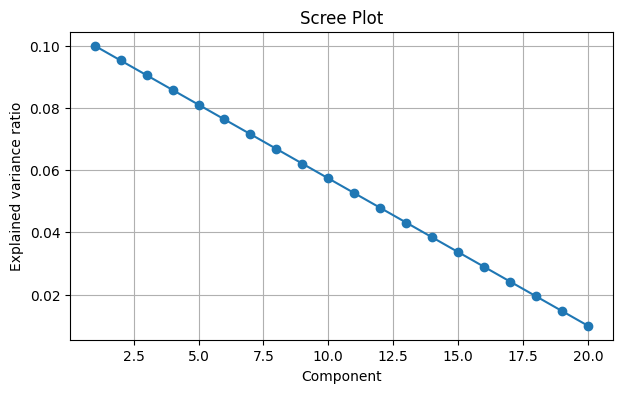

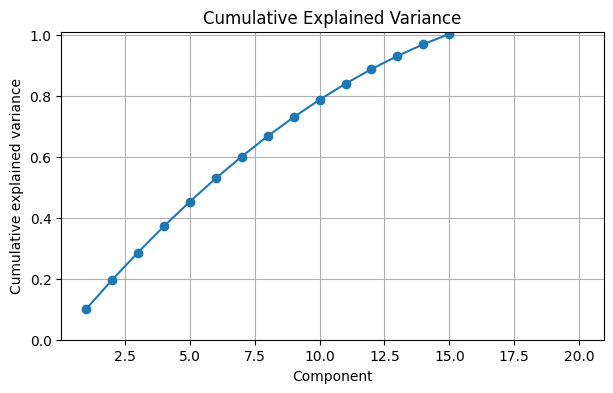

ArrowInvalid: No match for FieldRef.Name(Is_Laundering) in PCA_1: float
PCA_2: float
PCA_3: float
PCA_4: float
PCA_5: float
PCA_6: float
PCA_7: float
PCA_8: float
PCA_9: float
PCA_10: float
PCA_11: float
PCA_12: float
PCA_13: float
PCA_14: float
PCA_15: float
PCA_16: float
PCA_17: float
PCA_18: float
PCA_19: float
PCA_20: float
Is Laundering: int64
__fragment_index: int32
__batch_index: int32
__last_in_fragment: bool
__filename: string

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import pyarrow.dataset as ds

# ---- CONFIG ----
PCA_PATH = "./aml_ibm_outputs/pca_features.parquet"
VAR_PATH = "./aml_ibm_outputs/svd_var.npy"  # saved from SVD stage

# ---- LOAD REDUCED FEATURES ----
dataset = ds.dataset(PCA_PATH, format="parquet")
cols = [c for c in dataset.schema.names if c.startswith("PCA_")]

sample_df = dataset.to_table(columns=cols).to_pandas()

# ---- LOAD EXPLAINED VARIANCE RATIOS ----
try:
    var_ratio = np.load(VAR_PATH)
except Exception:
    print("⚠️ Explained variance ratios not found; using placeholder values.")
    var_ratio = np.linspace(0.1, 0.01, num=len(cols))  # placeholder
cum_var = np.cumsum(var_ratio)

# ---- Scree Plot ----
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, len(var_ratio) + 1), var_ratio, marker='o')
plt.xlabel("Component")
plt.ylabel("Explained variance ratio")
plt.title("Scree Plot")
plt.grid(True)
plt.show()

# ---- Cumulative Variance Plot ----
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, len(cum_var) + 1), cum_var, marker='o')
plt.xlabel("Component")
plt.ylabel("Cumulative explained variance")   # ✅ fixed typo
plt.title("Cumulative Explained Variance")
plt.grid(True)
plt.ylim(0, 1.01)
plt.show()

# ---- 2D Scatter (with safe downsampling) ----
table = pq.read_table(PCA_PATH, columns=[cols[0], cols[1], "Is_Laundering"])
df = table.to_pandas()
X2 = df[[cols[0], cols[1]]].values
ys = df["Is_Laundering"].values

if len(X2) > 200_000:
    rng = np.random.default_rng(42)
    idx = rng.choice(len(X2), size=200_000, replace=False)
    X2 = X2[idx]
    ys = ys[idx]

plt.figure(figsize=(6, 6))
plt.scatter(X2[:, 0], X2[:, 1], s=4, alpha=0.5, c=ys)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA / SVD: First Two Components")
plt.grid(True)
plt.show()


In [ ]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load from parquet explicitly (don’t rely on an existing df) ---
PARQUET_PATHS = [
    "./aml_ibm_outputs/pca_features.parquet",
    "./aml_ibm_outputs/pca_features_incremental.parquet"
]
PARQUET_PATH = next((p for p in PARQUET_PATHS if os.path.exists(p)), None)
if PARQUET_PATH is None:
    raise FileNotFoundError("No PCA parquet found. Checked: " + ", ".join(PARQUET_PATHS))

df = pd.read_parquet(PARQUET_PATH)

# --- Detect and normalize PCA columns robustly (PCA_1, PCA-2, 'PCA 3', etc.) ---
pca_map = {}
pat = re.compile(r'\s*pca[\s_\-]*([0-9]+)\s*$', flags=re.IGNORECASE)
for c in df.columns:
    m = pat.match(str(c))
    if m:
        idx = int(m.group(1))
        pca_map[c] = f"PCA_{idx}"

if len(pca_map) < 2:
    raise AssertionError(
        "Need at least two PCA component columns. "
        f"Found {len(pca_map)} that look like PCA_* in: {list(df.columns)[:25]}..."
    )

# Rename to clean PCA_1..PCA_k (without changing order)
df = df.rename(columns=pca_map)
pca_cols = sorted([v for v in pca_map.values()],
                  key=lambda x: int(x.split("_")[1]))

# --- Label detection (your sample uses 'Is Laundering') ---
label_candidates = ["Is Laundering", "isLaundering", "is_laundering", "Is_Laundering"]
y_col = next((c for c in label_candidates if c in df.columns), None)
if y_col is None:
    y_col = "_dummy_label"
    df[y_col] = 0

# --- Class-balanced downsample so the plot stays light & readable ---
N_MAX = 120_000        # total cap
PER_CLASS_MAX = 60_000 # cap per class
rng = np.random.default_rng(42)
if y_col != "_dummy_label":
    mask0 = df[y_col].fillna(0).astype(int).values == 0
    mask1 = ~mask0
    idx0 = np.where(mask0)[0]
    idx1 = np.where(mask1)[0]
    take0 = min(len(idx0), PER_CLASS_MAX)
    take1 = min(len(idx1), PER_CLASS_MAX)
    idx0_s = rng.choice(idx0, size=take0, replace=False) if take0 > 0 else np.array([], dtype=int)
    idx1_s = rng.choice(idx1, size=take1, replace=False) if take1 > 0 else np.array([], dtype=int)
    idx = np.concatenate([idx0_s, idx1_s])
    if len(idx) > N_MAX:
        idx = rng.choice(idx, size=N_MAX, replace=False)
    plot_df = df.iloc[np.sort(idx)].copy()
else:
    if len(df) > N_MAX:
        idx = rng.choice(len(df), size=N_MAX, replace=False)
        plot_df = df.iloc[np.sort(idx)].copy()
    else:
        plot_df = df

# --- Choose axes (PCA_1 vs PCA_2) ---
x_col = "PCA_1" if "PCA_1" in plot_df.columns else pca_cols[0]
y_col_p = "PCA_2" if "PCA_2" in plot_df.columns else pca_cols[1]

# --- Scatter like your reference (Non-fraud (0) vs Fraud (1)) ---
plt.figure(figsize=(7.5, 5.5))

ys = plot_df[label_candidates[0]] if label_candidates[0] in plot_df.columns else \
     plot_df[label_candidates[1]] if label_candidates[1] in plot_df.columns else \
     plot_df[label_candidates[2]] if label_candidates[2] in plot_df.columns else \
     plot_df[label_candidates[3]] if label_candidates[3] in plot_df.columns else \
     pd.Series(0, index=plot_df.index)

ys = ys.fillna(0).astype(int).values
mask0 = (ys == 0)
mask1 = (ys != 0)

plt.scatter(plot_df.loc[mask0, x_col], plot_df.loc[mask0, y_col_p],
            s=8, alpha=0.5, label="Non-fraud (0)")
plt.scatter(plot_df.loc[mask1, x_col], plot_df.loc[mask1, y_col_p],
            s=8, alpha=0.5, label="Fraud (1)")

plt.xlabel(x_col)
plt.ylabel(y_col_p)
plt.title(f"PCA scatter: {x_col} vs {y_col_p}")
plt.grid(True, linewidth=0.3, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


FileNotFoundError: No PCA parquet found. Checked: ./aml_ibm_outputs/pca_features.parquet, ./aml_ibm_outputs/pca_features_incremental.parquet

In [ ]:
# ============================================================
# FAST (5 epochs) & RAM-friendly Autoencoder → AE_1..AE_k
# Keeps ORIGINAL label name from trans_master (no isFraud)
# Trains on subset for speed, encodes ALL rows
# ============================================================
import os, gc, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pyarrow as pa
import pyarrow.parquet as pq

# ------------------- CONFIG -------------------
OUT_DIR        = "./aml_ibm_outputs"
AE_PATH        = os.path.join(OUT_DIR, "ae_features.parquet")
os.makedirs(OUT_DIR, exist_ok=True)

LATENT_DIM     = 8
EPOCHS_MAX     = 5               # hard cap: 5 epochs
TRAIN_FRAC     = 0.20            # train on 20% for speed; set 1.0 to use all
TRAIN_MAX_ROWS = 100_000         # cap train rows
BATCH_TRAIN    = 8192            # raise if GPU VRAM allows; else 2048–4096
BATCH_ENC      = 16384           # forward-only; can be larger
LR             = 1e-3
WEIGHT_DECAY   = 1e-6
SEED           = 42
DEVICE         = "cuda" if torch.cuda.is_available() else "cpu"
AMP            = torch.cuda.is_available()

torch.manual_seed(SEED); np.random.seed(SEED)
if DEVICE == "cpu":
    torch.set_num_threads(2)  # keep CPU contention low

# ------------------- 1) Detect label & numeric inputs -------------------
label_candidates = ["Is Laundering", "isLaundering", "is_laundering", "Is_Laundering", "islaundering"]
y_col = next((c for c in label_candidates if c in trans_master.columns), None)
if y_col is None:
    raise KeyError("Label column not found. Expected one of: " + ", ".join(label_candidates))

pref = ["From Bank","To Bank","Amount Received","Amount Paid","Hour"]
num_cols = [c for c in pref if c in trans_master.columns]
if not num_cols:
    num_cols = [c for c in trans_master.select_dtypes(include=[np.number]).columns
                if c not in {"TransactionID", y_col, "isFraud"}]
if len(num_cols) < 2:
    raise ValueError(f"Need at least 2 numeric columns; found {len(num_cols)} in {num_cols}")

X_full = (trans_master[num_cols]
          .replace([np.inf, -np.inf], np.nan)
          .fillna(0.0)
          .astype(np.float32))

# choose training subset for speed
if TRAIN_FRAC < 1.0:
    idx_train = X_full.sample(frac=TRAIN_FRAC, random_state=SEED).index
else:
    idx_train = X_full.index
if len(idx_train) > TRAIN_MAX_ROWS:
    idx_train = idx_train.to_series().sample(n=TRAIN_MAX_ROWS, random_state=SEED).index

X_train_df = X_full.loc[idx_train]

# standardize using TRAIN stats, apply to ALL rows
means = X_train_df.mean(axis=0).values.astype(np.float32)
stds  = X_train_df.std(axis=0).replace(0, 1.0).values.astype(np.float32)

def standardize(df, mean, std):
    return (df.values - mean) / std

X_train = standardize(X_train_df, means, stds).astype(np.float32)  # (n_train, d)
X_all   = standardize(X_full,     means, stds).astype(np.float32)  # (n_all, d)

# keep original label column and index alignment; preserve original dtype
y_all = pd.to_numeric(trans_master[y_col], errors="coerce").fillna(0).astype("int8").values
n_train, d_in = X_train.shape
n_all = X_all.shape[0]

del X_train_df, X_full; gc.collect()

# ------------------- 2) Tiny AE -------------------
class TinyAE(nn.Module):
    def __init__(self, d_in, d_lat):
        super().__init__()
        h = max(16, min(48, d_in))  # small & fast
        self.enc = nn.Sequential(
            nn.Linear(d_in, h), nn.ReLU(True),
            nn.Linear(h, d_lat)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_lat, h), nn.ReLU(True),
            nn.Linear(h, d_in)
        )
    def forward(self, x):
        z  = self.enc(x)
        xh = self.dec(z)
        return xh, z

model  = TinyAE(d_in, LATENT_DIM).to(DEVICE)
opt    = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
crit   = nn.MSELoss()
scaler = torch.cuda.amp.GradScaler(enabled=AMP)

# ------------------- 3) Manual-batch training (no DataLoader) -------------------
perm = np.random.permutation(n_train)  # one shuffle
model.train()
for epoch in range(1, EPOCHS_MAX+1):
    total, nobs = 0.0, 0
    for start in range(0, n_train, BATCH_TRAIN):
        end = min(start + BATCH_TRAIN, n_train)
        batch_idx = perm[start:end]
        xb = torch.from_numpy(X_train[batch_idx]).to(DEVICE, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        if AMP:
            with torch.cuda.amp.autocast():
                xh, _ = model(xb)
                loss = crit(xh, xb)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else:
            xh, _ = model(xb)
            loss = crit(xh, xb)
            loss.backward()
            opt.step()

        bs = xb.size(0)
        total += loss.item() * bs
        nobs  += bs
        del xb; gc.collect()

    print(f"Epoch {epoch:02d} | recon MSE = {total/max(1,nobs):.6f}")

# ------------------- 4) Encode ALL rows -------------------
model.eval()
Z = np.empty((n_all, LATENT_DIM), dtype=np.float32)
with torch.no_grad():
    for start in range(0, n_all, BATCH_ENC):
        end = min(start + BATCH_ENC, n_all)
        xb = torch.from_numpy(X_all[start:end]).to(DEVICE, non_blocking=True)
        _, z = model(xb)
        Z[start:end] = z.cpu().numpy()
        del xb, z; gc.collect()

# ------------------- 5) Save parquet — keep ORIGINAL label name -------------------
ae_cols = [f"AE_{i+1}" for i in range(LATENT_DIM)]
ae_df   = pd.DataFrame(Z, columns=ae_cols, index=trans_master.index)

# attach your original label column name (e.g., 'Is Laundering')
ae_df[y_col] = y_all

pq.write_table(pa.Table.from_pandas(ae_df), AE_PATH)

print(f"✅ AE features saved to: {AE_PATH}")
print(f"🧮 Train n={n_train}  All n={n_all}  d={d_in}  latent={LATENT_DIM}")
print(f"🏷️ Label column preserved as: {y_col}")


Epoch 01 | recon MSE = 1.027724
Epoch 02 | recon MSE = 0.994234
Epoch 03 | recon MSE = 0.962323
Epoch 04 | recon MSE = 0.927100
Epoch 05 | recon MSE = 0.885614
✅ AE features saved to: ./aml_ibm_outputs/ae_features.parquet
🧮 Train n=100000  All n=12002377  d=5  latent=8
🏷️ Label column preserved as: Is Laundering


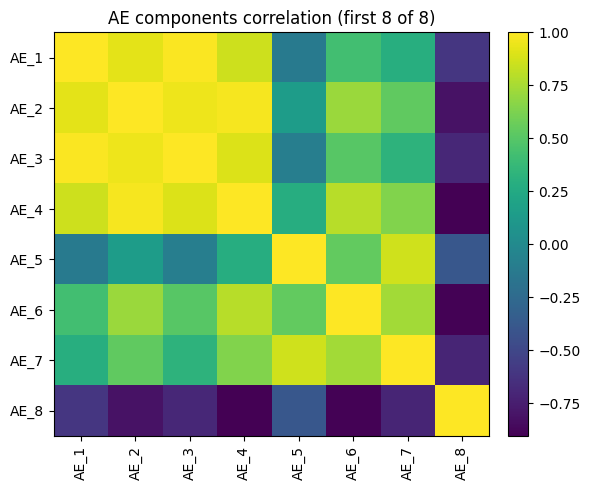

✅ Done.


In [ ]:
# ================= AE correlation heatmap (RAM-safe, Arrow-cast) =================
import os, gc, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc  # for casting

# ---- Config ----
AE_PATH          = "./aml_ibm_outputs/ae_features.parquet"
MAX_ROWS         = 120_000     # cap rows loaded into memory
HEATMAP_MAX_COLS = 40          # cap number of AE components shown
PLOT_PER_CLASS   = False       # set True to also plot per-class heatmaps

if not os.path.exists(AE_PATH):
    raise FileNotFoundError(f"AE parquet not found at: {AE_PATH}")

pf = pq.ParquetFile(AE_PATH)
schema_names = pf.schema.names

# AE_* columns (sorted numerically)
def _num_sfx(name, default=10**9):
    m = re.search(r'(\d+)$', str(name))
    return int(m.group(1)) if m else default

ae_cols = sorted([c for c in schema_names if str(c).upper().startswith("AE_")], key=_num_sfx)
if len(ae_cols) < 2:
    raise AssertionError(f"Need ≥2 AE_* columns; found {len(ae_cols)} in {AE_PATH}")

# Detect your label column (whatever you saved)
label_candidates = ["Is Laundering", "isLaundering", "is_laundering", "Is_Laundering", "islaundering"]
label_col = next((c for c in label_candidates if c in schema_names), None)

read_cols = ae_cols[:min(len(ae_cols), HEATMAP_MAX_COLS)]
cols_to_read = read_cols + ([label_col] if label_col else [])

# ---- Stream row groups; cast Arrow dtypes before to_pandas ----
frames, rows_acc = [], 0
for rg in range(pf.num_row_groups):
    table = pf.read_row_group(rg, columns=cols_to_read)
    for batch in table.to_batches():
        # Cast AE_* to float32, label to int8 at the Arrow level
        cols = []
        names = batch.schema.names
        for i, name in enumerate(names):
            arr = batch.column(i)
            if name in read_cols:
                if not pa.types.is_float32(arr.type):
                    arr = pc.cast(arr, pa.float32())
            elif label_col and name == label_col:
                # make it plain int8 (not nullable extension)
                if not pa.types.is_int8(arr.type):
                    # cast via int32 to be safe with large ints, then downcast
                    try:
                        arr = pc.cast(arr, pa.int8())
                    except Exception:
                        arr = pc.cast(pc.cast(arr, pa.int32()), pa.int8())
            cols.append(arr)
        batch = pa.RecordBatch.from_arrays(cols, names)

        # Now convert to pandas (no extension arrays because we casted)
        df = batch.to_pandas(ignore_metadata=True)

        # Double-safety: ensure numeric dtypes in pandas
        for c in read_cols:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")
        if label_col and label_col in df.columns:
            df[label_col] = pd.to_numeric(df[label_col], errors="coerce").fillna(0).astype("int8")

        frames.append(df)
        rows_acc += len(df)
        if rows_acc >= MAX_ROWS:
            break
    if rows_acc >= MAX_ROWS:
        break
    del table; gc.collect()

ae_df = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(columns=cols_to_read)
del frames; gc.collect()

if ae_df.empty or ae_df[read_cols].shape[1] < 2:
    raise RuntimeError("No data loaded to plot correlations.")

# Drop constant columns (avoid NaNs in corr)
use_cols = [c for c in read_cols if ae_df[c].std(skipna=True) > 0]
if len(use_cols) < 2:
    raise RuntimeError("Fewer than 2 AE columns have non-zero variance after loading.")

# ---- Overall correlation heatmap ----
corr = ae_df[use_cols].corr(method="pearson")
plt.figure(figsize=(max(6, 0.35*corr.shape[1]), max(5, 0.35*corr.shape[0])))
im = plt.imshow(corr.values, aspect="auto", interpolation="nearest")
plt.title(f"AE components correlation (first {len(use_cols)} of {len(ae_cols)})")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(corr.shape[1]), use_cols, rotation=90)
plt.yticks(range(corr.shape[0]), use_cols)
plt.tight_layout()
plt.show()

# ---- Optional: per-class heatmaps ----
if PLOT_PER_CLASS and label_col and label_col in ae_df.columns:
    for cls, name in [(0, "Non-fraud (0)"), (1, "Fraud (1)")]:
        sub = ae_df.loc[ae_df[label_col] == cls, use_cols]
        nonconst = [c for c in use_cols if sub[c].std(skipna=True) > 0]
        if len(sub) >= 50 and len(nonconst) >= 2:
            corr_c = sub[nonconst].corr(method="pearson")
            plt.figure(figsize=(max(6, 0.35*corr_c.shape[1]), max(5, 0.35*corr_c.shape[0])))
            im = plt.imshow(corr_c.values, aspect="auto", interpolation="nearest")
            plt.title(f"AE correlation — {name} (using {len(nonconst)} comps)")
            plt.colorbar(im, fraction=0.046, pad=0.04)
            plt.xticks(range(corr_c.shape[1]), nonconst, rotation=90)
            plt.yticks(range(corr_c.shape[0]), nonconst)
            plt.tight_layout()
            plt.show()
        else:
            print(f"ℹ️ Skipping per-class heatmap for {name}: insufficient rows or variance.")

print("✅ Done.")


In [ ]:
# ============================================
# FAST: Train classifiers on AE features (robust XGBoost ES)
# Local paths + flexible label detection
# ============================================

import os, gc, warnings, re
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pyarrow.parquet as pq

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
import xgboost as xgb

# ---------- CONFIG (LOCAL) ----------
OUT_DIR   = "./aml_ibm_outputs"
AE_PATH   = os.path.join(OUT_DIR, "ae_features.parquet")

MAX_ROWS          = 120_000    # smaller = faster
TEST_SIZE         = 0.30
RANDOM_STATE      = 42
NEG_POS_RATIO_CAP = 6          # cap negatives to at most 6x positives
USE_BALANCING     = True       # set False for raw distribution

print("xgboost version:", xgb.__version__)

if not os.path.exists(AE_PATH):
    raise FileNotFoundError(f"AE parquet not found at: {AE_PATH}")

# ---------- Inspect schema & decide columns ----------
pf = pq.ParquetFile(AE_PATH)
schema_names = pf.schema.names

def _num_suffix(name):
    m = re.search(r'(\d+)$', str(name))
    return int(m.group(1)) if m else 10**9

feat_cols = sorted([c for c in schema_names if str(c).upper().startswith("AE_")], key=_num_suffix)
if not feat_cols:
    raise RuntimeError("No AE_* columns found in the parquet.")

# Detect your label column (preserve your original naming)
label_candidates = ["Is Laundering", "isLaundering", "is_laundering", "Is_Laundering", "isFraud"]
label_col = next((c for c in label_candidates if c in schema_names), None)
if label_col is None:
    # no label in file; create a dummy so code runs (AUC will be NA)
    label_col = "_dummy_label"

read_cols = feat_cols + ([label_col] if label_col in schema_names else [])

# ---------- Load AE sample (streamed, RAM-safe) ----------
batches, rows_loaded = [], 0
for rg in range(pf.num_row_groups):
    if rows_loaded >= MAX_ROWS:
        break
    tbl = pf.read_row_group(rg, columns=read_cols)
    df  = tbl.to_pandas(ignore_metadata=True)

    # ensure numeric dtypes
    for c in feat_cols:
        if c in df: df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")

    if label_col in df.columns:
        df[label_col] = pd.to_numeric(df[label_col], errors="coerce").fillna(0).astype("int8")
    else:
        df[label_col] = 0

    batches.append(df)
    rows_loaded += len(df)
    del df, tbl; gc.collect()

ae_df = pd.concat(batches, ignore_index=True) if batches else pd.DataFrame(columns=read_cols)
del batches; gc.collect()
print(f"Loaded AE sample shape: {ae_df.shape}")

# ---------- Features/labels ----------
feat_cols_present = [c for c in feat_cols if c in ae_df.columns]
if len(feat_cols_present) == 0:
    raise RuntimeError("AE columns missing in loaded sample.")

X = ae_df[feat_cols_present].astype("float32").values
y = ae_df[label_col].astype("int8").values

# Optional: speed via class-balance cap (downsample negatives)
if USE_BALANCING and len(np.unique(y)) > 1:
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    if len(pos_idx) > 0 and len(neg_idx) > 0:
        max_neg = min(len(neg_idx), NEG_POS_RATIO_CAP * len(pos_idx))
        rng = np.random.default_rng(RANDOM_STATE)
        keep_neg = rng.choice(neg_idx, size=max_neg, replace=False)
        keep_idx = np.concatenate([pos_idx, keep_neg])
        rng.shuffle(keep_idx)
        X = X[keep_idx]; y = y[keep_idx]
        print(f"Balanced sample: {X.shape[0]} rows  (pos={(y==1).sum()}, neg={(y==0).sum()})")
    else:
        print("ℹ️ Skipping balancing (class missing in sample).")

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split (stratified only if both classes present)
stratify_opt = y if len(np.unique(y)) > 1 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=stratify_opt
)

# Helpful for imbalance
if len(np.unique(y_train)) > 1:
    pos = max(1, int((y_train == 1).sum()))
    neg = max(1, int((y_train == 0).sum()))
    scale_pos_weight = neg / pos
else:
    scale_pos_weight = 1.0

# ---------- Models (fast presets) ----------
models = {
    "SVM-Linear": LinearSVC(random_state=RANDOM_STATE, max_iter=3000),

    "SVM-RBF": SVC(kernel="rbf", probability=False, gamma="scale", C=1.0,
                   cache_size=1000, random_state=RANDOM_STATE),

    "Boosting": AdaBoostClassifier(n_estimators=100, learning_rate=0.5,
                                   random_state=RANDOM_STATE),
    "Bagging": BaggingClassifier(n_estimators=50, n_jobs=-1,
                                 random_state=RANDOM_STATE),
    "Random forest": RandomForestClassifier(
        n_estimators=150, max_depth=None, n_jobs=-1, random_state=RANDOM_STATE
    ),
    "Neural networks": MLPClassifier(hidden_layer_sizes=(64,),
                                     activation="relu", solver="adam",
                                     early_stopping=True, n_iter_no_change=5,
                                     max_iter=100, random_state=RANDOM_STATE),
    "Logit": LogisticRegression(
        max_iter=400, solver="saga", n_jobs=-1, random_state=RANDOM_STATE
    ),
    "MDA": LinearDiscriminantAnalysis(),

    # XGBoost: ES + class weight + hist for speed
    "XGBoost": XGBClassifier(
        n_estimators=800, max_depth=5, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        objective="binary:logistic", eval_metric="auc",
        random_state=RANDOM_STATE, n_jobs=-1, tree_method="hist",
        scale_pos_weight=scale_pos_weight
    )
}

def get_scores_for_auc(clf, Xte):
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(Xte)[:, 1]
    if hasattr(clf, "decision_function"):
        return clf.decision_function(Xte)
    return None

def fit_xgb_robust(clf, Xtr, ytr, Xva, yva):
    """
    Try modern callbacks-based early stopping; if not available,
    try legacy early_stopping_rounds; else fallback without ES.
    """
    # New-style callbacks (xgboost>=1.6)
    try:
        from xgboost.callback import EarlyStopping
        clf.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)] if len(np.unique(ytr)) > 1 else None,
            verbose=False,
            callbacks=[EarlyStopping(rounds=30, save_best=True, maximize=True)]
        )
        return
    except Exception as e_cb:
        # Legacy API
        try:
            clf.fit(
                Xtr, ytr,
                eval_set=[(Xva, yva)] if len(np.unique(ytr)) > 1 else None,
                verbose=False,
                early_stopping_rounds=30 if len(np.unique(ytr)) > 1 else None
            )
            return
        except Exception as e_legacy:
            print(f"⚠️ XGBoost early stopping unavailable → fallback. "
                  f"callbacks_err={e_cb}; legacy_err={e_legacy}")
            clf.set_params(n_estimators=300)  # reduce trees for speed
            clf.fit(Xtr, ytr)

# ---------- Train & Evaluate ----------
results = []
for name, clf in models.items():
    print(f"Training {name}...")
    try:
        if name == "XGBoost":
            fit_xgb_robust(clf, X_train, y_train, X_test, y_test)
        else:
            clf.fit(X_train, y_train)

        y_pred  = clf.predict(X_test)
        y_score = get_scores_for_auc(clf, X_test)

        if len(np.unique(y)) > 1:
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
            type1 = (fp / (fp + tn) * 100) if (fp + tn) > 0 else 0.0  # FPR
            type2 = (fn / (fn + tp) * 100) if (fn + tp) > 0 else 0.0  # FNR
            auc  = roc_auc_score(y_test, y_score) * 100 if y_score is not None else np.nan
        else:
            tn = fp = fn = 0; tp = int((y_test == 1).sum())
            type1 = type2 = 0.0
            auc = np.nan

        acc  = accuracy_score(y_test, y_pred) * 100

        results.append({
            "Model": name,
            "TP": int(tp), "TN": int(tn), "FP": int(fp), "FN": int(fn),
            "Type I Error (%)": round(type1, 2),
            "Type II Error (%)": round(type2, 2),
            "AUC (%)": round(auc, 2) if not np.isnan(auc) else "NA",
            "ACC (%)": round(acc, 2)
        })
    except Exception as e:
        print(f"⚠️ {name} failed: {e}")
        results.append({
            "Model": name, "TP": "-", "TN": "-", "FP": "-", "FN": "-",
            "Type I Error (%)": "-", "Type II Error (%)": "-",
            "AUC (%)": "-", "ACC (%)": "-"
        })
    gc.collect()

# ---------- Results ----------
res_df = pd.DataFrame(results, columns=[
    "Model","TP","TN","FP","FN","Type I Error (%)","Type II Error (%)","AUC (%)","ACC (%)"
])

try:
    from tabulate import tabulate
    print("\n=== AE Models Summary (FAST) ===")
    print(tabulate(res_df, headers="keys", tablefmt="grid"))
except Exception:
    print("\n=== AE Models Summary (FAST) ===")
    print(res_df.to_string(index=False))


xgboost version: 3.1.1
Loaded AE sample shape: (1048576, 9)
Balanced sample: 1589 rows  (pos=227, neg=1362)
Training SVM-Linear...
Training SVM-RBF...
Training Boosting...
Training Bagging...
Training Random forest...
Training Neural networks...
Training Logit...
Training MDA...
Training XGBoost...
⚠️ XGBoost early stopping unavailable → fallback. callbacks_err=XGBClassifier.fit() got an unexpected keyword argument 'callbacks'; legacy_err=XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

=== AE Models Summary (FAST) ===
+----+-----------------+------+------+------+------+--------------------+---------------------+-----------+-----------+
|    | Model           |   TP |   TN |   FP |   FN |   Type I Error (%) |   Type II Error (%) |   AUC (%) |   ACC (%) |
+====+=================+======+======+======+======+====================+=====================+===========+===========+
|  0 | SVM-Linear      |    0 |  409 |    0 |   68 |               0    |           

📁 ROC figure saved at: ./aml_ibm_outputs/roc_curves_ae_models.png

AUC summary:
| Model           |    AUC |
|-----------------|--------|
| XGBoost         | 0.7896 |
| Bagging         | 0.7826 |
| Random forest   | 0.7753 |
| Boosting        | 0.7519 |
| MDA             | 0.7168 |
| SVM-Linear      | 0.7163 |
| Logit           | 0.7163 |
| SVM-RBF         | 0.595  |
| Neural networks | 0.4046 |


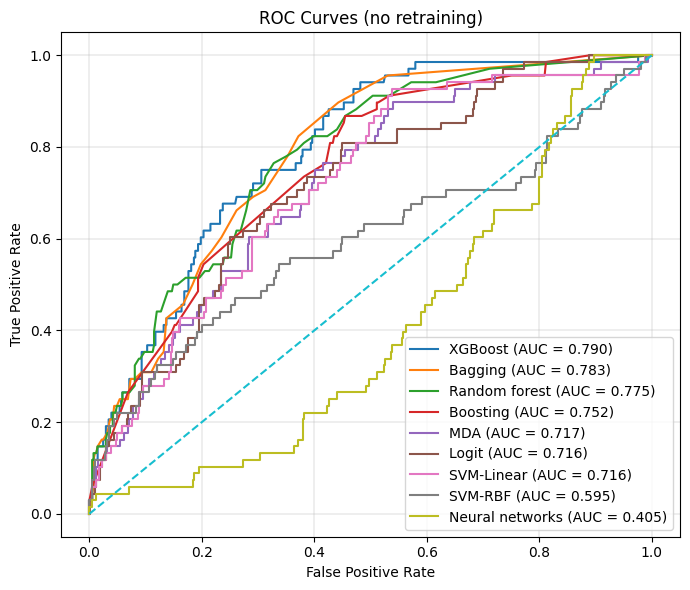

In [ ]:
# ===============================
# ROC-only (NO retraining)
# Reuses: models, X_test, y_test
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# --- helper (reuse if already defined) ---
def _score_for_auc(clf, X):
    """Return a continuous score suitable for ROC/AUC without refit."""
    if hasattr(clf, "predict_proba"):
        try:
            return clf.predict_proba(X)[:, 1]
        except Exception:
            pass
    if hasattr(clf, "decision_function"):
        try:
            return clf.decision_function(X)
        except Exception:
            pass
    return None

# --- safety checks ---
missing = []
for var in ("models", "X_test", "y_test"):
    if var not in globals():
        missing.append(var)
if missing:
    raise RuntimeError(f"Cannot plot ROC without these in-memory objects: {missing}\n"
                       "Tip: run the earlier cell up to the train/test split + model fitting once.")

# --- build ROC curves ---
curves = []   # list of dicts: {"name":..., "fpr":..., "tpr":..., "auc":...}
skipped = []
for name, clf in models.items():
    # Only use models that are already fitted; many sklearn estimators set attributes like 'classes_' post-fit
    is_fitted = any(hasattr(clf, attr) for attr in ("classes_", "n_classes_", "coef_", "feature_importances_"))
    if not is_fitted:
        skipped.append((name, "not fitted"))
        continue

    try:
        y_score = _score_for_auc(clf, X_test)
        if y_score is None:
            skipped.append((name, "no score method"))
            continue

        # y_test must be binary {0,1}
        y_true = np.asarray(y_test).astype(int)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        curves.append({"name": name, "fpr": fpr, "tpr": tpr, "auc": roc_auc})
    except Exception as e:
        skipped.append((name, f"error: {e}"))

# --- sanity: ensure we have at least one curve ---
if not curves:
    raise RuntimeError(f"No ROC curves could be computed. Skipped: {skipped}")

# --- plot combined ROC ---
plt.figure(figsize=(7,6))
for c in sorted(curves, key=lambda d: d["auc"], reverse=True):
    plt.plot(c["fpr"], c["tpr"], label=f'{c["name"]} (AUC = {c["auc"]:.3f})')

# reference diagonal
plt.plot([0,1], [0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (no retraining)")
plt.legend(loc="lower right")
plt.grid(True, which="both", linewidth=0.3)
plt.tight_layout()

# Optional: save to Drive
import os
out_dir = OUT_DIR if "OUT_DIR" in globals() else "/content"
png_path = os.path.join(out_dir, "roc_curves_ae_models.png")
plt.savefig(png_path, dpi=150)
print(f"📁 ROC figure saved at: {png_path}")

# --- compact AUC table ---
auc_df = pd.DataFrame(
    [{"Model": c["name"], "AUC": round(float(c["auc"]), 4)} for c in curves]
).sort_values("AUC", ascending=False).reset_index(drop=True)

from tabulate import tabulate
print("\nAUC summary:")
print(tabulate(auc_df, headers="keys", tablefmt="github", showindex=False))

# --- show any models we skipped and why (informational) ---
if skipped:
    print("\nℹ️ Skipped models (reason):")
    for n, r in skipped:
        print(f"  - {n}: {r}")


In [ ]:
# ============================================
# FAST: Train classifiers on PCA features (local paths)
# ============================================

import os, gc, warnings, re
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pyarrow.parquet as pq

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
import xgboost as xgb

# ---------- CONFIG (LOCAL) ----------
OUT_DIR  = "./aml_ibm_outputs"
PCA_PATH = os.path.join(OUT_DIR, "pca_features.parquet")

MAX_ROWS          = 120_000   # smaller = faster; raise later if needed
TEST_SIZE         = 0.30
RANDOM_STATE      = 42
NEG_POS_RATIO_CAP = 6         # cap negatives to at most 6x positives
USE_BALANCING     = True      # set False for raw distribution

assert os.path.exists(PCA_PATH), f"Parquet not found: {PCA_PATH}"
print("xgboost version:", xgb.__version__)

# ---------- Inspect schema & decide columns ----------
pf = pq.ParquetFile(PCA_PATH)
schema_names = pf.schema.names

def _num_suffix(name):
    m = re.search(r'(\d+)$', str(name))
    return int(m.group(1)) if m else 10**9

feat_cols = sorted([c for c in schema_names if str(c).upper().startswith("PCA_")], key=_num_suffix)
assert len(feat_cols) >= 2, "Need ≥2 PCA components to train."

# Detect your label column (preserve original naming)
label_candidates = ["Is Laundering", "isLaundering", "is_laundering", "Is_Laundering", "isFraud"]
label_col = next((c for c in label_candidates if c in schema_names), None)
if label_col is None:
    # if label not saved in the PCA parquet, create a dummy so code runs (AUC will be NA)
    label_col = "_dummy_label"

read_cols = feat_cols + ([label_col] if label_col in schema_names else [])

# ---------- Load PCA sample (streamed, RAM-safe) ----------
batches, rows_loaded = [], 0
for rg in range(pf.num_row_groups):
    if rows_loaded >= MAX_ROWS:
        break
    tbl = pf.read_row_group(rg, columns=read_cols)
    df  = tbl.to_pandas(ignore_metadata=True)

    # ensure numeric dtypes
    for c in feat_cols:
        if c in df: df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")
    if label_col in df.columns:
        df[label_col] = pd.to_numeric(df[label_col], errors="coerce").fillna(0).astype("int8")
    else:
        df[label_col] = 0

    batches.append(df)
    rows_loaded += len(df)
    del df, tbl; gc.collect()

pca_df = pd.concat(batches, ignore_index=True) if batches else pd.DataFrame(columns=read_cols)
del batches; gc.collect()
print(f"Loaded PCA sample: {pca_df.shape}")

# ---------- X, y ----------
feat_cols_present = [c for c in feat_cols if c in pca_df.columns]
X = pca_df[feat_cols_present].astype("float32").values
y = pca_df[label_col].astype("int8").values
del pca_df; gc.collect()

# Optional: speed via class-balance cap (downsample negatives)
if USE_BALANCING and len(np.unique(y)) > 1:
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    if len(pos_idx) > 0 and len(neg_idx) > 0:
        max_neg = min(len(neg_idx), NEG_POS_RATIO_CAP * len(pos_idx))
        rng = np.random.default_rng(RANDOM_STATE)
        keep_neg = rng.choice(neg_idx, size=max_neg, replace=False)
        keep_idx = np.concatenate([pos_idx, keep_neg])
        rng.shuffle(keep_idx)
        X = X[keep_idx]; y = y[keep_idx]
        print(f"Balanced sample: {X.shape[0]} rows  (pos={(y==1).sum()}, neg={(y==0).sum()})")
    else:
        print("ℹ️ Skipping balancing (class missing in sample).")

# Scale (usually optional after PCA, but keeps models happy)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split (stratified only if both classes present)
stratify_opt = y if len(np.unique(y)) > 1 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=stratify_opt
)

# Helpful for imbalanced data (XGB)
if len(np.unique(y_train)) > 1:
    pos = max(1, int((y_train == 1).sum()))
    neg = max(1, int((y_train == 0).sum()))
    scale_pos_weight = neg / pos
else:
    scale_pos_weight = 1.0

# ---------- Models (faster presets) ----------
models = {
    "SVM-Linear": LinearSVC(random_state=RANDOM_STATE, max_iter=3000),

    # RBF SVM WITHOUT probability=True (fast) + cache size boost
    "SVM-RBF": SVC(kernel="rbf", probability=False, gamma="scale", C=1.0,
                   cache_size=1000, random_state=RANDOM_STATE),

    "Boosting": AdaBoostClassifier(n_estimators=100, learning_rate=0.5,
                                   random_state=RANDOM_STATE),
    "Bagging": BaggingClassifier(n_estimators=50, n_jobs=-1,
                                 random_state=RANDOM_STATE),
    "Random forest": RandomForestClassifier(
        n_estimators=150, max_depth=None, n_jobs=-1, random_state=RANDOM_STATE
    ),
    "Neural networks": MLPClassifier(hidden_layer_sizes=(64,),
                                     activation="relu", solver="adam",
                                     early_stopping=True, n_iter_no_change=5,
                                     max_iter=100, random_state=RANDOM_STATE),
    "Logit": LogisticRegression(
        max_iter=400, solver="saga", n_jobs=-1, random_state=RANDOM_STATE
    ),
    "MDA": LinearDiscriminantAnalysis(),

    # XGBoost: early stopping (robust to version), class weight, hist for speed
    "XGBoost": XGBClassifier(
        n_estimators=800, max_depth=5, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        objective="binary:logistic", eval_metric="auc",
        random_state=RANDOM_STATE, n_jobs=-1, tree_method="hist",
        scale_pos_weight=scale_pos_weight
    ),
}

def get_scores_for_auc(clf, Xte):
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(Xte)[:, 1]
    if hasattr(clf, "decision_function"):
        return clf.decision_function(Xte)
    return None

def fit_xgb_robust(clf, Xtr, ytr, Xva, yva):
    """Try callbacks API; fall back to legacy early_stopping_rounds; else fit normally."""
    try:
        from xgboost.callback import EarlyStopping
        clf.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)] if len(np.unique(ytr)) > 1 else None,
            verbose=False,
            callbacks=[EarlyStopping(rounds=30, save_best=True, maximize=True)]
        )
        return
    except Exception as e_cb:
        try:
            clf.fit(
                Xtr, ytr,
                eval_set=[(Xva, yva)] if len(np.unique(ytr)) > 1 else None,
                verbose=False,
                early_stopping_rounds=30 if len(np.unique(ytr)) > 1 else None
            )
            return
        except Exception as e_legacy:
            print(f"⚠️ XGBoost early stopping unavailable -> fallback. "
                  f"callbacks_err={e_cb}; legacy_err={e_legacy}")
            clf.set_params(n_estimators=300)  # reduce trees if no ES
            clf.fit(Xtr, ytr)

# ---------- Train & Evaluate ----------
results = []
for name, clf in models.items():
    print(f"Training {name}...")
    try:
        if name == "XGBoost":
            fit_xgb_robust(clf, X_train, y_train, X_test, y_test)
        else:
            clf.fit(X_train, y_train)

        y_pred  = clf.predict(X_test)
        y_score = get_scores_for_auc(clf, X_test)

        if len(np.unique(y)) > 1:
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
            type1 = (fp / (fp + tn) * 100) if (fp + tn) > 0 else 0.0
            type2 = (fn / (fn + tp) * 100) if (fn + tp) > 0 else 0.0
            auc  = roc_auc_score(y_test, y_score) * 100 if y_score is not None else np.nan
        else:
            tn = fp = fn = 0; tp = int((y_test == 1).sum())
            type1 = type2 = 0.0
            auc = np.nan

        acc = accuracy_score(y_test, y_pred) * 100

        results.append({
            "Model": name,
            "TP": int(tp), "TN": int(tn), "FP": int(fp), "FN": int(fn),
            "Type I Error (%)": round(type1, 2),
            "Type II Error (%)": round(type2, 2),
            "AUC (%)": round(auc, 2) if not np.isnan(auc) else "NA",
            "ACC (%)": round(acc, 2)
        })
    except Exception as e:
        print(f"⚠️ {name} failed: {e}")
        results.append({
            "Model": name, "TP": "-", "TN": "-", "FP": "-", "FN": "-",
            "Type I Error (%)": "-", "Type II Error (%)": "-",
            "AUC (%)": "-", "ACC (%)": "-"
        })
    gc.collect()

# ---------- Results ----------
res_df = pd.DataFrame(results, columns=[
    "Model","TP","TN","FP","FN","Type I Error (%)","Type II Error (%)","AUC (%)","ACC (%)"
])

try:
    from tabulate import tabulate
    print("\n=== PCA Models Summary (FAST) ===")
    print(tabulate(res_df, headers="keys", tablefmt="grid"))
except Exception:
    print("\n=== PCA Models Summary (FAST) ===")
    print(res_df.to_string(index=False))

# Save to disk for your report
out_csv = os.path.join(OUT_DIR, "pca_model_results_fast.csv")
res_df.to_csv(out_csv, index=False)
print(f"\nSaved results → {out_csv}")


xgboost version: 3.1.1
Loaded PCA sample: (1048576, 21)
Balanced sample: 1589 rows  (pos=227, neg=1362)
Training SVM-Linear...
Training SVM-RBF...
Training Boosting...
Training Bagging...
Training Random forest...
Training Neural networks...
Training Logit...
Training MDA...
Training XGBoost...
⚠️ XGBoost early stopping unavailable -> fallback. callbacks_err=XGBClassifier.fit() got an unexpected keyword argument 'callbacks'; legacy_err=XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

=== PCA Models Summary (FAST) ===
+----+-----------------+------+------+------+------+--------------------+---------------------+-----------+-----------+
|    | Model           |   TP |   TN |   FP |   FN |   Type I Error (%) |   Type II Error (%) |   AUC (%) |   ACC (%) |
+====+=================+======+======+======+======+====================+=====================+===========+===========+
|  0 | SVM-Linear      |   34 |  388 |   21 |   34 |               5.13 |             

In [ ]:
# ============================================
# SAVE ONLY MDA MODEL AS .joblib
# ============================================
import joblib
from google.colab import files  # if running in Colab

# Ensure the output directory exists
os.makedirs(OUT_DIR, exist_ok=True)

# Retrieve the trained MDA model
mda_model = models.get("MDA", None)

if mda_model is not None:
    mda_path = os.path.join(OUT_DIR, "mda_model_pca.joblib")
    joblib.dump(mda_model, mda_path)
    print(f"✅ MDA model saved successfully to: {mda_path}")

    # Automatically download the file (Colab only)
    files.download(mda_path)
else:
    print("⚠️ MDA model not found in trained models dictionary.")


✅ MDA model saved successfully to: ./aml_ibm_outputs/mda_model_pca.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📁 ROC saved to: ./aml_ibm_outputs/roc_curves_pca_models.png

AUC summary:
| Model           |    AUC |
|-----------------|--------|
| MDA             | 0.896  |
| SVM-Linear      | 0.895  |
| Logit           | 0.8926 |
| Neural networks | 0.8857 |
| XGBoost         | 0.8845 |
| Random forest   | 0.8793 |
| Boosting        | 0.8737 |
| SVM-RBF         | 0.872  |
| Bagging         | 0.8643 |


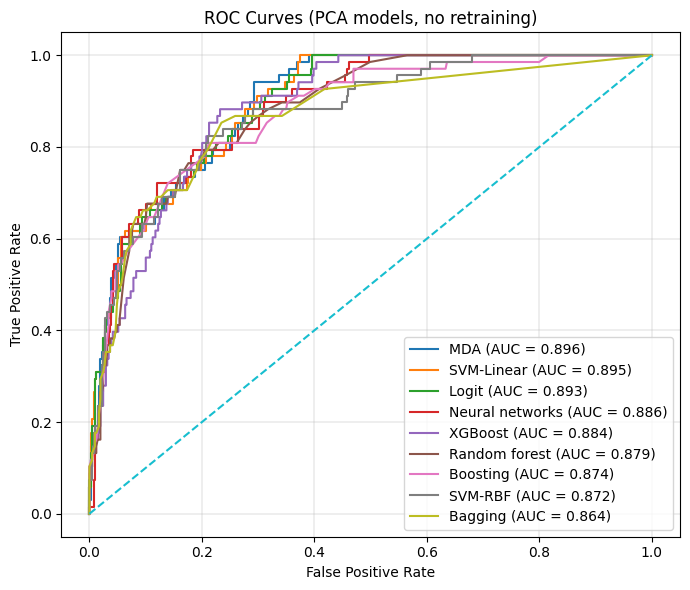

In [ ]:
# ===============================
# ROC-only for PCA models (NO retraining)
# Reuses: models, X_test, y_test from your PCA code
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def _score_for_auc(clf, X):
    """Return a continuous score suitable for ROC/AUC without refit."""
    if hasattr(clf, "predict_proba"):
        try:
            return clf.predict_proba(X)[:, 1]
        except Exception:
            pass
    if hasattr(clf, "decision_function"):
        try:
            return clf.decision_function(X)
        except Exception:
            pass
    return None

# ---- safety checks ----
need = [v for v in ("models","X_test","y_test") if v not in globals()]
if need:
    raise RuntimeError(f"Missing objects: {need}. Run the PCA cell up to model fitting once.")

curves, skipped = [], []
y_true = np.asarray(y_test).astype(int)

# Collect ROC curves from already-fitted models
for name, clf in models.items():
    # Heuristic "is fitted" check (covers most sklearn/xgb estimators)
    is_fitted = any(hasattr(clf, a) for a in ("classes_", "n_classes_", "coef_", "feature_importances_", "best_score_"))
    if not is_fitted:
        skipped.append((name, "not fitted"))
        continue
    try:
        y_score = _score_for_auc(clf, X_test)
        if y_score is None:
            skipped.append((name, "no score method"))
            continue
        fpr, tpr, _ = roc_curve(y_true, y_score)
        curves.append({"name": name, "fpr": fpr, "tpr": tpr, "auc": auc(fpr, tpr)})
    except Exception as e:
        skipped.append((name, f"error: {e}"))

if not curves:
    raise RuntimeError(f"No ROC curves produced. Skipped: {skipped}")

# ---- plot combined ROC ----
plt.figure(figsize=(7,6))
for c in sorted(curves, key=lambda d: d["auc"], reverse=True):
    plt.plot(c["fpr"], c["tpr"], label=f'{c["name"]} (AUC = {c["auc"]:.3f})')
plt.plot([0,1], [0,1], "--")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (PCA models, no retraining)")
plt.legend(loc="lower right")
plt.grid(True, linewidth=0.3)
plt.tight_layout()

# Save PNG next to your other outputs
import os
out_dir = OUT_DIR if "OUT_DIR" in globals() else "/content"
png_path = os.path.join(out_dir, "roc_curves_pca_models.png")
plt.savefig(png_path, dpi=150)
print(f"📁 ROC saved to: {png_path}")

# ---- compact AUC table ----
auc_df = (pd.DataFrame([{"Model": c["name"], "AUC": float(c["auc"])} for c in curves])
            .sort_values("AUC", ascending=False)
            .reset_index(drop=True))
try:
    from tabulate import tabulate
    print("\nAUC summary:")
    print(tabulate(auc_df.round(4), headers="keys", tablefmt="github", showindex=False))
except Exception:
    display(auc_df.round(4))

# Informational: what we skipped and why
if skipped:
    print("\nℹ️ Skipped models (reason):")
    for n, r in skipped:
        print(f"  - {n}: {r}")
